# Selección de clientes DynHybridFL - Método basado en recursos

En este notebook vamos a entrenar un modelo de ML utilizando el paradigma de Aprendizaje Federado [1] para los problemas de clasificación de dígitos manuscritos MNIST [2] y clasificación de imágenes a color CIFAR-10 [3]. Usaremos estos dos problemas de visión por computador para la implementación y análisis de rendimiento del método de selección de clientes basado en recursos Dyn-HybridFL que implementa una mejora de rendimiento frente a su algoritmo base HybridFL para la gestión dinámica del $T_\text{round}$.
> [1] https://arxiv.org/abs/1602.05629
>
> [2] http://yann.lecun.com/exdb/mnist
>
> [3] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [4] https://arxiv.org/abs/1905.07210

In [1]:
# install FLEXible framework if not installed
try:
    import flex
    print("FLEXible is installed.")
except:
    print("FLEXible is not installed.\nInstalling dependency flexible-fl...")
    !pip install flexible-fl

FLEXible is not installed.
Installing dependency flexible-fl...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 1.6 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 4.2 MB/s eta 0:00:00a 0:00:01
  Created wheel for cardinality: filename=cardinality-0.1.1-py3-none-any.whl size=2587 sha256=72ba75325919e990d7f397261ee9ed24118c29f259bda6b25f491b90fe3a682d
  Stored in directory: /root/.cache/pip/wheels/b8/19/d1/2665c004b583a7d1880fa59055a3e462d6e35841a01b57010b
Successfully built cardinality


In [2]:
# install Torchsummary if not installed
try:
    import torchsummary
    print("torchsummary is installed.")
except:
    print("torchsummary is not installed.\nInstalling dependency torchsummary...")
    !pip install torchsummary

torchsummary is not installed.
Installing dependency torchsummary...


In [3]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(loss, accuracy, title="Learning Curves"):
    # Example data
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'g', label='Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)

    # Show the plots
    plt.tight_layout()
    plt.show()

In [4]:
import torch

# select device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cuda'

# Cargar datasets - MNIST, CIFAR-10


## Distribución de los datos

Para la distribución de los datos preparamos una federación para ambos datasets en el que simulamos clientes __heterogéneos__ en cuestión tanto de clases como del tamaño de sus conjuntos de datos. Nos basamos en la federación que realizan en [1].

Para poder crear un escenario de clientes heterogéneos, suponemos un dataset de $10$ clases que puede ser cualquiera de los que estamos utilizando (MNIST o CIFAR-10). Luego realizamos una federación con la siguiente descripción de [1]: _"muestrear dos/diez clases para cada cliente para CIFAR-10/CIFAR-100$^1$; Luego, para cada cliente $i$ y una clase seleccionada $c$, muestreamos $\alpha_{i,c} \sim U(.4, .6)$, y lo asignamos con $\frac{\alpha_{i,c}}{\sum_j{\alpha_{j,c}}}$ de los ejemplos para esta clase. Repetimos lo anterior para $10, 50$ y $100$ clientes."_ De esta forma, creamos una distribución de datos en el que cada cliente tendrán un número de clases diferente al resto y con diferentes tamaños, formando una distribución no-IID de datos.

> $^1$ En nuestro caso solo será para CIFAR-10 y MNIST, es decir, suponemos siempre $10$ clases.
>
> [1] https://arxiv.org/abs/2103.04628.

## MNIST
El primero será MNIST (Modified National Institute of Standards and Technology database), que consiste en imágenes de $28$ pixeles de ancho y alto en escala de grises de dígitos manuscritos del $0$ al $9$. Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{28\times 28}, x_i \in \{1, ..., 255\}$, donde $x_i$ es un pixel de la imagen $X$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ que representa el dígito al que corresponde la imagen. El conjunto de entrenamiento consta de $N=240,000$ imágenes.

El dataset descargado será el de _Extended MNIST_ [1], que comprende una versión extendida del concepto original de MNIST para proporcionar dígitos y letras manuscritas, una cantidad más grande de datos, diferentes formas de separar los datos (solo dígitos, letras, por clase, ...), etc. Nosotros solo utilizaremos los dígitos para entrenar el clásico MNIST, del cual su versión extendida consta de $N = 280,000$ imágenes de dígitos manuscritos.

Para poder federar EMNIST, debemos de crear una configuración con `FedDatasetConfig` para poder especificar como queremos distribuir los datos y a cuántos nodos queremos federarlo y luego utilizar la clase `FedDataDistribution` para poder crear el dataset federado. Definimos también las transformaciones a realizar a los datos que son simplemente normalizar cada pixel a valores de $[0,1]$ (función `ToTensor()`) y normalizar los valores de cada pixel con una media y desviación estándar de $0.5$.

> [1] https://www.nist.gov/itl/products-and-services/emnist-dataset

In [5]:
import math
import numpy as np

from copy import deepcopy
from torchvision import datasets, transforms
from flex.data import Dataset, FedDatasetConfig, FedDataDistribution

K_mnist = 1000

train_data = datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=None  # we apply them later in training process
)

test_data = datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=None  # we apply them later in training process
)

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = K_mnist

# assign a sample proportion for each node-class pair (https://arxiv.org/abs/2404.06127)
num_classes = 10
alphas = np.random.uniform(low=0.4, high=0.6, size=(config.n_nodes, num_classes))
alphas = alphas / np.sum(alphas, axis=0)
config.weights_per_class = alphas

# create Federated data distribution of MNIST
flex_dataset_mnist = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data), config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_mnist[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36684138.20it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1005091.97it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2100513.20it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3047109.53it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## CIFAR-10

El segundo dataset es CIFAR-10 (_Canadian Institute for Advanced Research_)[1], el cual es otro de los datasets junto con MNIST, más utilizados en el campo del Deep Learning y Visión por Computador. CIFAR-10 consiste en una colección de imágenes de $32$ pixeles de altura y de ancho a color ($3$ canales RGB) representando $10$ objetos reales:
- Avión (airplane)
- Automóvil (automobile)
- Pájaro (bird)
- Gato (cat)
- Ciervo (deer)
- Perro (dog)
- Rana (frog)
- Caballo (horse)
- Barco (ship)
- Camión (truck)

Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{32\times 32 \times 3}, x_i \in \{1, ..., 255\}$, donde $x_i^c$ es un pixel de la imagen $X$ en el canal $c$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ tal que indexa la lista de clases $C=(c_0=\text{plane}, c_1=\text{automobile}, ..., c_9=\text{truck})$. El conjunto de entrenamiento consta de $N=50,000$ datos de entrada.

Realizamos la misma serie de operaciones que con EMNIST, para el mismo número de clientes, $K = 1000$ (sin contar el servidor). Definimos también las transformaciones para escalar los valores a $[0,1]$ y normalizar con medias y desviaciones estándar específicas de CIFAR-10 [2].

> [1] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [2] https://github.com/kuangliu/pytorch-cifar/issues/19

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from flex.data import FedDataDistribution, FedDatasetConfig, Dataset

K_cifar = 1000

train_data = datasets.CIFAR10(
    root=".",
    train=True,
    download=True,
    transform=None,  # we apply them later in training process
)

test_data = datasets.CIFAR10(
    root=".",
    train=False,
    download=True,
    transform=None,  # we apply them later in training process
)

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = K_cifar

num_classes = 10

# assign a sample proportion for each node-class pair
alphas = np.random.uniform(low=0.4, high=0.6, size=(config.n_nodes, num_classes))
alphas = alphas / np.sum(alphas, axis=0)
config.weights_per_class = alphas

# create Federated data distribution of CIFAR-10
flex_dataset_cifar = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data),
    config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_cifar[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalizar con las medias y desviaciones estándar específicas de CIFAR-10
])

100%|██████████| 170498071/170498071 [00:01<00:00, 95658997.43it/s] 


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


# Modelos de aprendizaje

Definimos dos modelos de Machine Learning, uno para cada uno de los dos datasets que hemos definido anteriormente. Para ambos problemas, usaremos como función de pérdida o _criterion_ la función de entropía cruzada o _Cross Entropy Loss_ cuya definición [1] la define como (para una muestra $n$):

$$l_n = -w_{y_n} \cdot \log \frac{\exp (x_n, y_n)}{\sum_{c=0}^C \exp (x_n, c)} =-w_{y_n}\cdot \log (\text{Softmax} (x_n, y_n))$$

En ambos problemas utilizaremos Adam [2] como optimizador o algoritmo de aprendizaje. Utilizaremos los mismos parámetros que en [2] al haber hecho los experimentos sobre modelos similares y con los mismos datasets que estamos usando y que han demostrando buenos resultados: $\eta = 0.01$ y $\beta_1 = 0.9,\beta_2 = 0.999$. Estos parámetros están definidos por defecto en la librería de PyTorch [3].

> [1] https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
>
> [2] https://arxiv.org/abs/1412.6980
>
> [3] https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

---




## Perceptrón Multicapa (MNIST)

El primero, que lo usaremos para ajustar MNIST, será un Perceptrón Multicapa (MLP) de dos capas ocultas de $128$ unidades la primera y $10$ la segunda (correspondiente al número de clases), y usando ReLU [1] como función de activación.

El modelo inicialmente lo tendrá el servidor y será copiado a cada uno de los clientes. En FLEX usamos el decorador `@init_model_server` para inicializar el modelo en el servidor, donde también podemos además de nuestra arquitectura del modelo, el optimizador y la función de pérdida a usar.

> [1] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [7]:
from typing import Tuple

import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """
    Multi-layer Perceptron classifier with two hidden layers.
    """
    def __init__(self, in_features: Tuple[int, int], hidden_features: int, num_classes: int = 10):
        super().__init__()

        width, height = in_features

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(width * height, hidden_features)
        self.fc2 = nn.Linear(hidden_features, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [8]:
import torchsummary

torchsummary.summary(MLP((28, 28), 128).to(device), (1, 28, 28), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
            Linear-3                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


## Red Neuronal Convolucional (CNN) - CIFAR-10

Para nuestro segundo problema, que consta de ajustar un modelo para clasificar CIFAR-10, utilizaremos un red neuronal convolucional o CNN. A diferencia de MNIST, CIFAR-10 tiene unos datos de entrada con una dimensionalidad más compleja, por lo que utilizar una CNN reduciría la cantidad de parámetros necesarios a entrenar.

Usaremos la red neuronal convolucional usada en la configuración experimental de HybridFL, que consiste en una CNN estándar que consiste en _"seis capas de convolución de 3 × 3 (con 32, 32, 64, 64, 128 y 128 canales, cada una de las cuales se activaba utilizando ReLU y se normalizaba por lotes, y cada dos de las cuales estaban seguidas de un max pooling de 2 × 2), seguidas de tres capas completamente conectadas (con 512 y 192 unidades activadas utilizando ReLU [2] y otras 10 unidades activadas utilizando soft-max)."_ [1].

> [1] https://arxiv.org/abs/1905.0721
>
> [2] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [9]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    """
    Convolucional Neural Net classifier for CIFAR-10 image recognition (32x32 images).

    Model architecture taken from HybridFL experimental setting:
    - https://arxiv.org/abs/1905.07210
    """
    def __init__(self, in_channels: int, in_width: int = 32, in_height: int = 32, output_dim: int = 10):
        super(CNN, self).__init__()

        self.in_channels = in_channels
        self.input_w = in_width
        self.input_h = in_height
        self.num_classes = output_dim

        # Pooling Layer (applied every two layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # First layer
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        output_w_1, output_h_1 = self.__conv_output_dims(
            self.input_w, self.input_h, 3, 1
        )

        # Second layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        output_w_2, output_h_2 = self.__conv_output_dims(
            output_w_1, output_h_1, 3, 1
        )

        # after pooling
        output_w_2, output_h_2 = self.__pool_output_dims(
            output_w_2, output_h_2, 2, 2
        )

        # Third layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        output_w_3, output_h_3 = self.__conv_output_dims(
            output_w_2, output_h_2, 3, 1
        )

        # Fourth layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        output_w_4, output_h_4 = self.__conv_output_dims(
            output_w_3, output_h_3, 3, 1
        )

        # after pooling
        output_w_4, output_h_4 = self.__pool_output_dims(
            output_w_4, output_h_4, 2, 2
        )

        # Fifth layer
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        output_w_5, output_h_5 = self.__conv_output_dims(
            output_w_4, output_h_4, 3, 1
        )

        # Sixth layer
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        output_w_6, output_h_6 = self.__conv_output_dims(
            output_w_5, output_h_5, 3, 1
        )

        # after pooling
        output_w_6, output_h_6 = self.__pool_output_dims(
            output_w_6, output_h_6, 2, 2
        )

        # Fully-Connected layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=int(output_w_6 * output_h_6 * 128), out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=self.num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # softmax applied on loss function
        return x

    def __conv_output_dims(self, width: int, height: int, kernel_size: int, padding: int = 1):
        output_w = width - kernel_size + 2 * padding + 1
        output_h = height - kernel_size + 2 * padding + 1
        return output_w, output_h

    def __pool_output_dims(self, width: int, height: int, kernel_size: int, stride: int = 1):
        output_w = np.floor((width - kernel_size) / stride) + 1
        output_h = np.floor((height - kernel_size) / stride) + 1

        return output_w, output_h

In [10]:
torchsummary.summary(CNN(in_channels=3, output_dim=10).to(device), (3, 32, 32), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
       BatchNorm2d-4           [-1, 32, 32, 32]              64
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
            Conv2d-8           [-1, 64, 16, 16]          36,928
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 128, 8, 8]         147,584
      BatchNorm2d-14            [-1, 12

# Configuración básica de escenario de FL

Configuraremos un escenario de aprendizaje federado centralizado (CFL) usando la librería FLEXible. FLEXible [1], o simplemente FLEX, es una librería de Python que proporciona un framework para la construcción de entornos de aprendizaje federado para fines de investigación y simulación. FLEX pretende dar flexibilidad en cuanto la gran variedad de escenarios y necesidades que se pueden llegar a plantear para experimentar en entornos federados.

Uno de nuestros objetivos es _integrar_ un método o técnica de selección de clientes en un escenario inicial de FL. La flexibilidad de FLEX nos permitirá conseguir este objetivo gracias a su flujo de mensajes entre entidades separadas por roles, y por la arquitectura modular de estas que nos permiten almacenar información de manera conveniente [1].

> [1] https://arxiv.org/abs/2404.06127
---

## Inicialización del modelo del servidor

El primer paso de nuestro bucle de entrenamiento en aprendizaje federado es inicializar el modelo FLEX del servidor (que posteriormente se distribuirá a los clientes).

Con FLEX podemos hacer uso del decorador `init_server_model` para facilitarnos esta tarea. Esta función entonces debe de instanciar y devolver un modelo de FLEX en donde además definimos el modelo de aprendizaje $^1$, la función de pérdida, el optimizador y cualquier otra información que se usará en las demás fases de la ronda de entrenamiento.

Definimos dos funciones que realizan esta tarea, dos para cada una de nuestras arquitecturas, el Perceptrón Multicapa y la Red Neuronal Convolucional. Como habíamos especificado en el planteamiento del problema de ML a resolver, utilizaremos el optimizador SGD-Adam con sus parámetros por defecto, y la Cross-Entropy como función de pérdida.

> $^1$ No se debe confundir el modelo de tipo `FlexModel` con un modelo de ML. El primero implementa el bloque fundamental que define una entidad en el escenario de FL (donde almacenamos información, sus datos locales, su modelo de aprendizaje, ...). El segundo es un modelo aprendizaje como lo puede ser un módulo de PyTorch o Tensorflow que realiza el aprendizaje automático y la predicción sobre los datos. Se dejará claro la diferencia entre los dos tipos de modelos.


In [11]:
import torch.nn as nn
import torch.nn.functional as F

from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel

mnist_in_features = (28, 28)
mnist_hidden_features = 128

@init_server_model
def build_server_model_mlp():
    server_flex_model = FlexModel()

    server_flex_model["model"] = MLP(mnist_in_features, mnist_hidden_features)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

cifar_in_channels = 3
cifar_num_classes = 10

@init_server_model
def build_server_model_cnn():
    server_flex_model = FlexModel()

    server_flex_model["model"] = CNN(in_channels=cifar_in_channels, output_dim=cifar_num_classes)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

---
## Distribuir modelo del servidor

El siguiente paso a realizar en un flujo de entrenamiento de aprendizaje federado es la distribución del modelo del servidor a los cientes. Con FLEX, podemos utilizar el decorador `@deploy_server_model` para distribuir el modelo del servidor a los clientes, definiendo una función que devuelva el modelo a almacenar en cada cliente.

En este caso, realizamos una copia profunda del modelo del servidor que será asignado a cada cliente.


In [12]:
from flex.pool import deploy_server_model
import copy


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    print(server_flex_model.keys())
    return copy.deepcopy(server_flex_model)

## Actualización del modelo del lado del cliente

Definimos la función encargada de realizar el entrenamiento del modelo sobre los datos locales del cliente. A esta función, es conveniente pasarle como parámetros los hiperparámetros de entrenamiento de un modelo de ML convencional como el número de épocas $E$ y el tamaño de _batch_ $B$

In [13]:
from flex.data import Dataset
from torch.utils.data import DataLoader


def train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse kwargs
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get client data as a torchvision object
    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)

    # get model
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]

    # train model
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()


## Obtener los parámetros de los clientes

Ahora implementamos la función que hace que el servidor (con rol de agregador) recupere los nuevos parámetros actualizados de los clientes. Con el decorador `@collect_clients_weights` recuperamos los pesos de PyTorch de cada cliente seleccionado para esa ronda. En el caso de PyTorch, el modelo devuelve los pesos en forma de un diccionario con `state_dict` para el que cada nombre representa una capa de la red y sus parámetros, lo que hacemos será devolver una lista con los valores de ese diccionario correspondientes a los pesos de la red entera.

In [14]:
from flex.pool import collect_clients_weights


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    return [weight_dict[name] for name in weight_dict]

## Agregación de los parámetros

El servidor/agregador agrega entonces estos nuevos parámetros para conseguir el nuevo modelo global. Utilizamos el decorador `@aggregate_weights` para poder agregar los pesos que hemos recuperado de los clientes en la fase anterior computando la media de los pesos de manera uniforme, conocido como agregador FedAvg [1], donde realizamos la media por columnas para cada capa de pesos.

> [1] https://arxiv.org/abs/1602.05629

In [15]:
from flex.pool import aggregate_weights
import tensorly as tl

tl.set_backend("pytorch")


@aggregate_weights
def aggregate_with_fedavg(list_of_weights: list):
    agg_weights = []
    for layer_index in range(len(list_of_weights[0])):
        weights_per_layer = [weights[layer_index] for weights in list_of_weights]
        weights_per_layer = tl.stack(weights_per_layer)
        weights_per_layer = weights_per_layer.clone().detach().float().requires_grad_(True)   # ensure is floating-point type
        agg_layer = tl.mean(weights_per_layer, axis=0)
        agg_weights.append(agg_layer)
    return agg_weights

Finalmente, agregamos los pesos al modelo de nuestro servidor/agregador. Sencillamente, para cada capa de nuestro modelo, realizamo una copia del nuevo que hemos agregado en la fase anterior.

In [16]:
from flex.pool import set_aggregated_weights


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    with torch.no_grad():
        weight_dict = server_flex_model["model"].state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(new)

## Evaluación del modelo global

Podemos evaluar el modelo del servidor sobre el dataset de test que hemos definido anteriormente que residía en el mismo servidor. Para ello, definimos una función `evaluate_global_model` que obtenga las predicciones del modelo con el dataset de test y devuelva las metricas resultantes, que en este caso son simplemente la pérdida y la _accuracy_.

In [17]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = test_data.to_torchvision_dataset(transform=mnist_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=256, shuffle=True, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc

## Training loop

A continuación se muestra el bucle de entrenamiento aplicando todas las fases que hemos implementado anteriormente. En esta versión básica se implementa una selección aleatoria (RandomSampling), similar a la propuesta en [1] donde se selecciona de manera aleatoria y uniforme $M$ clientes para la ronda actual. Este proceso se repite de forma iterativa un número determinado de rondas.

In [18]:
from typing import Literal

Problem = Literal["mnist", "cifar"]

def train_n_rounds(pool: FlexPool, n_rounds: int, clients_per_round=20, problem: Problem = "mnist"):
    """
    FL training loop for a certain number of rounds and clients selected.
    """
    # select transformations depending on problem to solve
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    losses = []
    accuracies = []
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")
        selected_clients_pool = pool.clients.select(clients_per_round)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")
        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # Each selected client trains her model
        selected_clients.map(train, transforms=transforms)
        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)
        pool.aggregators.map(aggregate_with_fedavg)
        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

    return losses, accuracies

# Selección de clientes con HybridFL

Ahora vamos a adaptar nuestro entorno de aprendizaje federado para utilizar el método de selección de clientes HybridFL [1].

HybridFL, así como otros algoritmos basados en recursos como FedCS [2] (del cual éste y muchos otros se basan), necesitan ser testeados bajo un entorno experimental que simule de forma realista y adecuada los requisitos de tiempo de reloj de cada una de las fases en aprendizaje federado. Tanto HybridFL como FedCS simulan cada uno de estos tiempos en un entorno dedicado de _Mobile Edge Computing_ (MEC) en el que hay un servidor central, denominado _Parameter Server_ o PS, una estación base o BS (que sirve de servidor en el eje o _edge server_), y una red de dispositivos móviles. En nuestro caso, podemos simular este entorno simplemente haciendo que las fases de entrenamiento como de subida de datos sean "agendadas" (_scheduled_), de manera que cumplan un cierto tiempo de reloj determinado antes de completarse. De esta manera, se verá reflejado el impacto que tendrá la estrategia de selección mediante la estimación de estos recursos.

---


## Inicialización de los recursos de los clientes

El siguiente paso para construir este entorno de simulación es determinar los recursos iniciales que tendrán los clientes. Los clientes son en esencia dispositivos (e.g. móviles, coches inteligentes, SmartTVs, ...) que tienen ciertas especificaciones que definen los recursos que posee. HybridFL así como FedCS, consideran dos tipos de recursos en los dispositivos:

- Recursos de comunicación inalámbrica: que influye directamente en la comunicación entre el servidor y los clientes (e.g ancho de banda en red, congestión de la red, _Resource Blocks_ $^1$). Podemos determinar la capacidad de comunicación de los clientes con el servidor en __cuánta cantidad de información es capaz de enviar en un segundo__, a lo que también se le conoce como _throughput_, y utilizamos como unidades estándar Mbit/s.

- Recursos computacionales: que influye en las actualizaciones del modelo en los clientes. HybridFL implementa el concepto de entrenamiento centralizado en el servidor; por tanto, como una suposición estándar en FL, suponemos que el servidor central tiene suficiente potencia computacional como para sobrepasar a los clientes en velocidad por la existencia de _stragglers_ [4]. Por lo que el tiempo de actualización de reloj del servidor la suponemos __nula o despreciable__. Podemos determinar la capacidad computacional de los clientes como __el número de ejemplos que puede procesar en un segundo__ actualizar el modelo [1].

- Permiso de subida de datos: este tipo de recurso, propio de HybridFL, es básicamente el permiso del cliente de subir sus datos al servidor, cuyo número de clientes se asume muy pequeño (menos del $\%1$ como mínimo [1]).

Por tanto, para poder muestrear en cada ronda de FL los recursos de los clientes, inicializamos primero las capacidades computacionales y de comunicación medias de cada cliente, de manera que en cada ronda se puedan samplear con una distribución Gaussiana truncada [5] como lo hacen los autores en [1]. Concretamente, el _throughput_ medio de los clientes se ha extraído de los experimentos hechos en un entorno simulado de comunicaciones inalámbricas de [1], en el que concluyeron que los clientes presentaban un _throughput_ de $\theta^{\text{avg}}_{k} = 1.4$ Mbit/s de media y un máximo de hasta $8.6$ Mbit/s, que resultan valores realistas en una red LTE. En cuanto a la capacidad computacional, se muestrea el número de datos procesados por segundo en entrenamiento de una distribución uniforme $\gamma^{\text{avg}}_{k} \sim U(10, 100)$. Finalmente, se elige de forma aleatoria y uniforme si el cliente $k$ permite su subida de datos en un ratio de $r_{\text{UL}} = 0.01$.

> $^1$ Aunque el número de bloques de recursos o RBs (la unidad mínima de ancho de banda en LTE [3]) puede influir significativamente en el tiempo de comunicación entre el servidor y los clientes, seguiremos la suposición de [2] por el que los RBs asignados a cada cliente son los mismos para todos, de esta manera solo nos preocupan factores más fluctuantes en casos reales como el ancho de banda.
>
> [1] https://arxiv.org/abs/1905.07210
>
> [2] https://arxiv.org/abs/1804.08333
>
> [3] _S. Sesia, M. Baker, and I. Toufik, LTE-the UMTS Long Term Evolution: From Theory to Practice. John Wiley & Sons, 2011_
>
> [4] G. Wang, C. Zhao, Q. Qi, R. Han, L. Bai and J. Choi, "Efficient Federated Learning via Joint Communication and Computation Optimization," in IEEE Transactions on Vehicular Technology, doi: 10.1109/TVT.2024.3379742.
>
> [5] https://en.wikipedia.org/wiki/Truncated_normal_distribution

In [19]:
from copy import deepcopy

# ratio of clients that permit their data to be uploaded
DEFAULT_R_UPLOAD = 0.01

# realistic client average throughput in Mbit/s
AVG_THROUGHPUT = 1.4

def init_client_resources(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse arguments
    r_upload = kwargs["r_upload"] if "r_upload" in kwargs else DEFAULT_R_UPLOAD

    ## Computation capability - data samples per second
    avg_comp = np.random.uniform(10, 100)

    ## Communication capability - Mbit per second
    avg_thr = AVG_THROUGHPUT

    # client permits data upload
    data_upload = np.random.rand() < r_upload

    client_flex_model["avg_thr"] = avg_thr
    client_flex_model["avg_comp"] = avg_comp
    client_flex_model["data_upload"] = data_upload

    # save Nk
    client_flex_model["n_samples"] = len(client_data)

    # save amount of data for each class
    labels = client_data.to_numpy()[1]
    unique, counts = np.unique(labels, return_counts=True)
    client_flex_model["n_samples_per_class"] = dict(zip(unique, counts))

    # if client permit data to be uploaded, make their dataset public
    if data_upload:
        client_flex_model["public_data"] = client_data

## Petición de recursos

A continuación, implementamos la función `resource_request` en la que el servidor/agregador comunica a $\lceil K \times C \rceil$ clientes (siendo $K$ el total de clientes y $C$ la fracción de clientes a seleccionar por ronda) seleccionados aleatoriamente, a notificarle de los recursos que poseen para la ronda actual, así como notificarle si permiten su subida de datos al servidor. Esta tarea se realizará de la siguiente manera:

1. El servidor inicializará en su modelo de FLEX, un diccionario para cada recurso e información adicional, en el que las claves de los mismos será el identificador del cliente en cuestión.
2. Para cada cliente, se recuperará los valores medios de las capacidades computacionales (el número de ejemplos procesados por unidad de tiempo) y de comunicación (_throughput_), así como también si permiten su subida de los datos.
    - Con esta información, para el cliente en cuestión, se muestrea la capacidad computacional y de comunicación para la ronda actual de una distribución normal truncada (usamos la librería de `scipy` [1] para muestrear aleatoriamente de esta distribución) con los valores medios recuperados de los clientes $^1$. Para el muestreo de la distribución normal truncada se usa una variancia para ambos tipos de recursos de $r_{\text{var}} = 0.2$.
    - Finalmente, con los recursos muestreados para la ronda actual, se pueden calcular los tiempos estimados de actualización y subida: $t^{\text{UL}}_k$ y $t^{\text{UD}}_k$ respectivamente. Que se usarán tanto para la selección de clientes y de datos como para el entrenamiento y subida de modelos agendados.

Definimos además una función `get_model_size` que calcula el tamaño en bytes de un modelo de aprendizaje. Esto nos servirá para estimar el tiempo que tarda un cliente con cierto _throughput_ en subir un modelo mediante la siguiente formula:
$$t_{k}^{\text{UL}} = D_m / \theta_k^{(t)}$$

siendo $D_m$ el tamaño en Mbit del modelo, y $\theta_k^{(t)}$ el _throughput_ del cliente $k$ en la ronda $t$.

El tiempo estimado en actualizar un modelo en un cliente $k$ (i.e. entrenar un modelo) se calcula con la siguiente formula:
$$t_k^{\text{UD}} = \frac{E \times N_k}{\gamma_k^{(t)}}$$

siendo $E$ el número de épocas de entrenamiento, $N_k$ el número de ejemplos que posee el cliente $k$ y $\gamma_k^{(t)}$ el número de ejemplo procesados por unidad de tiempo para entrenar el modelo en el cliente $k$ en la ronda $t$.

> $^1$ Nótese que conceptualmente, este muestreo de la capacidad de comunicación y computacional del cliente es lo que este último realmente notifica al servidor y no sus valores medios.
>
> [1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html

In [20]:
import sys
import torch.nn as nn

def get_model_size(model: nn.Module) -> int:
    """
    Get the size in bytes of a PyTorch learning model.
    """
    total_size = 0
    for param in model.parameters():
        total_size += param.numel() * param.element_size()

    return int(total_size)

In [21]:
from typing import List
from scipy.stats import truncnorm

# loose for simulated capabilities
r_var = 0.2

def resource_request(agg_model: FlexModel, client_flex_models: List[FlexModel], **kwargs):
    """
    Requests resource capabilities and whether or not they permit their data to
    be uploaded for M selected clients randomly.
    """
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5

    # get model size in bytes
    if "model_size" in agg_model.keys():
        model_size = agg_model["model_size"]
    else:
        model_size = get_model_size(agg_model["model"])

        # store model size in server model
        agg_model["model_size"] = model_size


    # indexed resources for each selected client saved in the aggregator
    agg_model["comp_resources"] = {}
    agg_model["comm_resources"] = {}
    agg_model["client_t_update"] = {}
    agg_model["client_t_upload"] = {}
    agg_model["permit_data_upload"] = {}
    agg_model["client_data"] = {}
    agg_model["client_n_samples_per_class"] = {}

    for k in client_flex_models:
        # get client average computational and communications capabilities
        avg_comp_cap = client_flex_models[k]["avg_comp"]
        avg_thr = client_flex_models[k]["avg_thr"]
        permit_data_upload = client_flex_models[k]["data_upload"]

        ## Computational capability - data samples processed per second to train
        std_dev_comp = 0.1 * avg_comp_cap

        # compute lower and upper bounds
        a, b = (1 - r_var) * avg_comp_cap, (1 + r_var) * avg_comp_cap
        a = (a - avg_comp_cap) / std_dev_comp
        b = (b - avg_comp_cap) / std_dev_comp

        comp_cap = truncnorm.rvs(a, b, loc=avg_comp_cap, scale=std_dev_comp, size=1)[0]

        # compute estimated update time
        n_samples = client_flex_models[k]["n_samples"]
        t_update = (epochs * n_samples) / comp_cap

        ## Communication capability - Mbit per second
        std_dev_thr = 0.1 * avg_thr

        # compute lower and upper bounds
        a, b = (1 - r_var) * avg_thr, (1 + r_var) * avg_thr
        a = (a - avg_thr) / std_dev_thr
        b = (b - avg_thr) / std_dev_thr

        comm_cap = truncnorm.rvs(a, b, loc=avg_thr, scale=std_dev_thr, size=1)[0]

        # compute estimated upload time in seconds
        t_upload = (model_size * 8) / (comm_cap * 1_000_000)

        # save resource capabilities for client k in current round
        agg_model["comp_resources"][k] = comp_cap
        agg_model["comm_resources"][k] = comm_cap

        # save estimated update and upload times
        agg_model["client_t_update"][k] = t_update
        agg_model["client_t_upload"][k] = t_upload

        # also save estimated times in clients to simulate scheduled training
        client_flex_models[k]["t_update"] = t_update
        client_flex_models[k]["t_upload"] = t_upload

        ## Client Data
        if permit_data_upload:
            agg_model["client_data"][k] = client_flex_models[k]["public_data"]

        # set data upload permit
        agg_model["permit_data_upload"][k] = permit_data_upload

        ## Amount of data for each class
        agg_model["client_n_samples_per_class"][k] = client_flex_models[k]["n_samples_per_class"]

## Selección de clientes

La selección de los clientes es un algoritmo de tipo _greedy_ en el que se busca maximizar el número de clientes seleccionados $𝕊$ sujeto a un cierto _deadline_ de tiempo por ronda $T_\text{round}$:
$$
\max |𝕊| \\
\text{s.t.} \ T_\text{round} \ge T_\text{cs} + T_{𝕊}^{\text d} + \Theta_{|𝕊|} + T_\text{agg}
$$
siendo $T_\text{cs}$ el tiempo de selección de clientes, $T_{𝕊}^{\text d}$ el tiempo de distribución del modelo global a los clientes seleccionados, $\Theta_{|𝕊|}$ el tiempo transcurrido desde el inicio de la actualización de los modelos hasta que el $k_i$-ésimo cliente haya actualizado y subido sus parámetros al servidor (más información en como se calcula este tiempo en [1]) y $T_\text{agg}$ el tiempo que toma al servidor agregar los parámetros de los clientes.

Como en [1] y [2], nosotros suponemos que el servidor tiene vastos recursos y que por tanto los tiempos de selección y agregación son despreciables: $T_\text{cs} = T_\text{agg} = 0$.

El algoritmo de selección en HybridFL [2] varía del de FedCS [1] en cuanto a que en el primero se elige el cliente con tiempo estimado mínimo mientras que en [1] se elige el que tenga la inversa del tiempo máximo. Como podemos darnos cuenta las dos formas son equivalentes. En nuestro caso optamos por la minimización de la función (i.e. elegir el cliente con menor tiempo estimado agregado). En HybridFL [2], esta función de tiempo transcurrido si se incluye el cliente $k$ al conjunto de seleccionados se le denomina $T_{\text{inc}}(𝕊, k)$.

En [2] además, se elige el cliente con $T_{\text{inc}}$ menor multiplicado por un coeficiente de variación $CV(N_r)$ que penaliza la función a minimizar si los datos de los clientes tienen un alto nivel de desbalance entre clases, de manera que se pueda sanitizar el problema de datos No-IID en los clientes en esa ronda de selección. Mas información sobre como calcular este coeficiente en [2].

> [1] https://arxiv.org/abs/1905.07210
>
> [2] https://arxiv.org/abs/1804.08333

---

Para poder implementar la selección de los clientes, tenemos primero que definir:
1. Por un lado, una función que calcule el tiempo de distribución del modelo a cada cliente.
2. Una función para calcular el tiempo estimado transcurrido si incluimos un cliente $k$ al conjunto de clientes seleccionados $𝕊$, $T_{\text{inc}}(𝕊, k)$.
3. Y por último, una función para calcular el coeficiente de variación $CV(N_r)$.

En el caso de $T_\text{round}$ esta será calculada por cada llamada a `client_selection` que dependerá de los recursos de los clientes actuales y los de la ronda anterior. Esta característica es el factor diferencial con HybridFL convencional, dando lugar a Dyn-HybridFL.

Para el _deadline_ de ronda inicial $T_\text{round}^{(0)}$, utilizamos el $T_\text{round}$ usado en el algoritmo HybridFL de $3$ minutos como punto inicial.

In [22]:
def T_model_dist(model_size: int, throughputs: list):
    """
    Computes the estimated time it takes to distribute the model to all clients synchronically.

    If throughputs is empty, then time is 0 (no clients to distribute to).
    """
    if not throughputs:
        return 0

    res = (model_size * 8) / (min(throughputs) * 1_000_000)
    return res

In [23]:
def T_inc(agg_model: FlexModel, S: set, k: int, elapsed_time: int):
    """
    Computes estimate elapsed time when client k is included to selected set of clients S.
    """
    t_upload = agg_model["client_t_upload"][k]
    t_update = agg_model["client_t_update"][k]

    # get model size to estimate dist time
    model_size = agg_model["model_size"]

    # throughputs of clients in S
    S_thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S]

    # throughputs of clients in S + {k}
    S_plus_k_thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S or client == k]

    return T_model_dist(model_size, S_plus_k_thr) - T_model_dist(model_size, S_thr) + t_upload + max(0, t_update - elapsed_time)

In [24]:
def CV(agg_model: FlexModel, S: set, classes: list):
    """
    Computes the coefficient of variation of data samples per class in clients in set S.
    """
    # get total number of data samples per class
    Nr = {}
    for k in agg_model["client_n_samples_per_class"]:
        if k not in S:
            continue

        k_counts = agg_model["client_n_samples_per_class"][k]
        Nr = {key: Nr.get(key, 0) + k_counts.get(key, 0) for key in set(Nr) | set(k_counts)}

    # fill up for all classes
    Nr = {key: Nr.get(key, 0) for key in classes}

    L = len(classes)
    n_mean = sum(Nr.values()) / L

    # compute the variance of the amount of data per class
    variance = sum((n_l - n_mean)**2 for n_l in Nr.values()) / L

    # return the coefficient of variance with respect to the mean
    return variance / n_mean

In [25]:
from flex.data import Dataset
from statistics import mean

DEFAULT_T_ROUND = 3 * 60

def client_selection(agg_model: FlexModel, agg_data: Dataset):
    ## compute T_round
    # compute current phi
    mean_t_update = mean(list(agg_model["client_t_update"].values()))
    mean_t_upload = mean(list(agg_model["client_t_upload"].values()))

    phi = mean_t_update + mean_t_upload

    # retrieve previous phi or same current phi if it's first round
    prev_phi = agg_model["current_phi"] if "current_phi" in agg_model.keys() else phi

    # update current phi
    agg_model["current_phi"] = phi

    # retrieve previous t_round
    prev_t_round = agg_model["current_t_round"] if "current_t_round" in agg_model.keys() else DEFAULT_T_ROUND

    # change t_round dynamically by speed up on the previous phi
    speed_up = prev_phi / phi
    t_round = prev_t_round * speed_up

    # update current t_round
    agg_model["current_t_round"] = t_round

    print("Previous T round:", prev_t_round)
    print("Current T round:", t_round)

    # stats for t_round
    agg_model["max_tround"] = max(agg_model["max_tround"] if "max_tround" in agg_model.keys() else 0, t_round)
    agg_model["min_tround"] = min(agg_model["min_tround"] if "min_tround" in agg_model.keys() else 1_000_000, t_round)
    print("Max T round:", agg_model["max_tround"])
    print("Min T round:", agg_model["min_tround"])

    ## Client selection
    # get classes of the ML task
    classes = agg_model["classes"]

    # get client indices
    Kp = set(agg_model["comp_resources"].keys())

    # initialize set of selected clients to train locally
    S = set()

    # initialize time budget
    t = 0

    # function to minimize
    def f(x):
        return T_inc(agg_model, S, x, t)

    while len(Kp) > 0:
        x = min(Kp, key=lambda k: f(k) * CV(agg_model, S | {k}, classes))

        # remove selected from Kp
        Kp.remove(x)

        # check time deadline
        tp = t + T_inc(agg_model, S, x, t)
        if tp < t_round:
            # add client if time deadline is met
            t = tp
            S.add(x)

    return S

## Selección de datos

En esta fase, el servidor recupera todos los datos de los clientes que permitieron la subida de sus datos $D_u$, y el servidor entonces selecciona los ejemplos según un criterio de selección que depende del _deadline_ $t^\text{UD}$, que es el tiempo decidido para el que cuentan los clientes en subir sus datos antes de que el primer cliente en actualizar el modelo suba sus parámetros. En HybridFL [1], se proponen dos formas de seleccionar los datos que conforman el conjunto de datos final $D^\text{UL}$ para el que el servidor actualiza el modelo global:
1. El primero es seleccionar de manera _greedy_ los ejemplos del cliente con mayor _throughput_ en orden.
2. En el segundo, el servidor intenta construir un conjunto de datos IID de la misma forma que en el primero solo que en vez de hacerlo en orden, lo hace por clase, de manera que se distribuyan los datos de manera idéntica. El dataset $D^\text{UL}$ ya cuenta con la propiedad de ser uniformemente distribuído por haber seleccionado los clientes de forma aleatoria en la fase de __Petición de Recursos__.

> [1] https://arxiv.org/abs/1905.07210

In [26]:
import gc
from flex.data import Dataset

def data_selection(agg_model: FlexModel, agg_data: Dataset, **kwargs):
    S = kwargs["S"]

    # get clients that permit their data to be uploaded and they are not selected to train
    U = [u for u in agg_model["permit_data_upload"] if agg_model["permit_data_upload"][u] and u not in S]

    print(f"Number of clients in U: {len(U)}")

    t_upload_deadline = min(agg_model["client_t_update"].values())

    classes = agg_model["classes"]

    # masks to skip samples indices from client data
    removal_masks = {u: [] for u in agg_model["client_data"]}

    def client_has_class(k: int, label: int):
        labels = agg_model["client_data"][k].to_numpy()[1]

        # remove already taken samples
        removal_mask = removal_masks[k]
        filtered_classes = np.delete(labels, removal_mask, axis=0)

        res = filtered_classes[filtered_classes == label].size > 0

        return res

    def empty_client_data():
        samples = []
        for u in U:
            d_x, d_y = agg_model["client_data"][u].to_numpy()
            filtered_d_x = np.delete(d_x, removal_masks[u], axis=0)
            filtered_d_y = np.delete(d_y, removal_masks[u], axis=0)
            samples.append(filtered_d_x.size)

        return sum(samples) == 0

    D_ul_X = []
    D_ul_y = []
    flag = True
    t_data_upload = 0

    while flag:
        print("Time upload:", t_data_upload)

        for l in classes:
            # get client with maximum throughput with class l samples
            x = max([u for u in U if client_has_class(u, l)], key=lambda k: agg_model["comm_resources"][k], default=None)

            # if there's no client with l class, just continue with the other class
            if not x:
                # check if there's data before continuing to avoid infinite loop
                flag = not empty_client_data()
                continue

            d_x, d_y = agg_model["client_data"][x].to_numpy()

            # filter data with label l
            mask = np.where(d_y == l)[0].tolist()

            # filter already taken samples
            mask = [i for i in mask if i not in removal_masks[x]]

            # take next first sample of class l
            d = d_x[mask][0]

            # compute data upload time
            u_thr = agg_model["comm_resources"][x]
            D_sample = d.nbytes + np.array(l).nbytes   # size of sample

            t_u = (D_sample * 8) / (u_thr * 1_000_000)

            if (t_data_upload + t_u) <= t_upload_deadline:
                # add d to D_ul
                D_ul_X.append(d)
                D_ul_y.append(l)

                # remove d from D_ul
                removal_masks[x].append(mask[0])

            # check deadline
            if (t_data_upload + t_u) >= t_upload_deadline:
                flag = False

            # finish if clients data are empty
            if empty_client_data():
                flag = False
                break

            # update data upload time
            t_data_upload += t_u
            
        # security check when not found any more data and didn't check deadline
        if t_data_upload >= t_upload_deadline:
            flag = False

    return np.array(D_ul_X), np.array(D_ul_y)

## Distribución del modelo global

Redefinimos la subrutina de `copy_server_model_to_clients` visto en la configuración básica, para copiar solo la información que deben de compartir los clientes con el servidor, es decir, no debemos distribuir la información almacenada propia del servidor a los clientes y solo la que nos interesa. Esto viene a darse porque FLEX por defecto copia el modelo del servidor entero, y por tanto se copiaría los datos de los clientes $D_u$, información de los recursos de todos los clientes, etc.

Para solo distribuir la información que nos interesa a los clientes, distribuimos toda la información del servidor para las claves que estén en la lista de claves de distribución (_white list_).

In [27]:
from flex.pool import deploy_server_model
import copy

white_list = [
    "model",
    "criterion",
    "optimizer_func",
    "optimizer_kwargs"
]

@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    white_listed = {key: value for key, value in server_flex_model.items() if key in white_list}
    return copy.deepcopy(white_listed)

Creamos una subrutina del servidor para poder simular el tiempo de distribución de los modelos a los clientes. Esta función pretende ser ejecutada _luego_ o _antes_ de copiar el servidor del modelo a los clientes.

In [28]:
import time
from tqdm import tqdm
from flex.pool import FlexPool
from flex.data import Dataset

def scheduled_model_distribution(agg_model: FlexModel, _: Dataset, **kwargs):
    # get model size
    model_size = agg_model["model_size"]

    # get selected clients
    S: set = kwargs["S"]

    # get client throughputs
    thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S]

    # compute Time of Distribution
    t_dist = T_model_dist(model_size, thr)

    # simulate Time of Distribution of the model by sleeping
    with tqdm(total=t_dist, desc="Distributing model...") as pbar:
        interval = 0.1
        for _ in range(int(t_dist / interval)):
            time.sleep(interval)
            pbar.update(interval)

## Actualización y subida del modelo agendado

Como hemos explicado anteriormente, para simular el tiempo que se estima en la actualización del modelo en los clientes, definimos la función de entrenamiento `scheduled_train` el cual entrena de la manera convencional que hemos visto en la configuración básica del entorno FL, pero esta vez, el tiempo transcurrido de esta función está sujeto a cumplir el tiempo de actualización para ese cliente como mínimo. De manera que se refleje el impacto de la selección de tal cliente en la duración total del entrenamiento del modelo global.

Los clientes cuando terminan de entrenar su modelo, inmediatamente lo suben al servidor, por lo que también simularemos la subida agendada del modelo actualizado por el cliente en esta función simplemente _durmiendo_ el hilo de ejecución sobre su tiempo de subida $t^{UL}_k$.

In [29]:
import time

def scheduled_train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get scheduled update and upload time
    t_update = client_flex_model["t_update"]
    t_upload = client_flex_model["t_upload"]

    # start timer
    start = time.time()

    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

    # stop timer and get effective training time
    end = time.time()
    training_time = end - start

    # simulate scheduled updating and uploading time by sleeping
    time.sleep(max(0, t_update - training_time) + t_upload)

En cuanto a la actualización del modelo de forma centralizada en el servidor con la función `centralized_train`, donde realizamos el mismo bucle de entrenamiento pero en este caso _sin agendar_, debido a que hemos supuesto que el tiempo de entrenamiento del servidor era despreciable comparado con los cliente, y que por tanto no tendría ningún impacto en el tiempo transcurrido de entrenamiento federado. También, ante la posibilidad de que no se haya podido recuperar datos del cliente (e.g. $U = 0$), indicamos con un campo booleano si el servidor ha podido actualizar el modelo o no; para de esta manera saber _a posteriori_ si agregamos los pesos del servidor si y solo si son nuevos parámetros. En cuanto a su tiempo de subida, es evidente que $t^{UL}_\text{server} = 0$ puesto que los parámetros están ya en el servidor.

In [30]:
def centralized_train(server_model: FlexModel, _test_data: Dataset, **kwargs):
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get client data
    X, y = kwargs["client_data"]

    if y.size == 0:
        # model has not been updated by server
        server_model["trained"] = False
        return

    client_data = Dataset.from_array(X, y)

    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    model = server_model["model"]
    optimizer = server_model["optimizer_func"](
        model.parameters(), **server_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = server_model["criterion"]
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

    # server has updated the model
    server_model["trained"] = True

El hilo de ejecución de los clientes se realiza en manera paralela y no secuencial tanto para la actualización de los modelos como su subida. Sin embargo, FedCS (y por tanto HybridFL) establece que las subidas de los modelos se realizan de manera síncrona y secuencial; por tanto, para simular el tiempo que debería durar la actualización y subida de los modelos vamos a definir una función en la que el servidor _duerme_ su hilo de ejecución por el tiempo necesario para simular la actualización paralela y la subida secuencial de los modelos, es decir, el tiempo transcurrido $\Theta_{S_t}$ [1]. En caso de que la ejecución en paralelo haya tomado más tiempo que $\Theta_{S_t}$, simplemente no dormimimos el hilo de ejecución.

> [1] Detalles en cómo calcular $\Theta_{S_t}$ en https://arxiv.org/abs/1804.08333.

In [31]:
import time
from flex.pool import FlexPool
from flex.data import Dataset

def simulate_model_update_upload(server_model: FlexModel, _: Dataset, **kwargs):

    # function to compute the time elapsed of clients parallel training and sequential upload
    def compute_simulation_time(S: list, elapsed_time=0):
        k = S[0]
        theta = elapsed_time + server_model["client_t_upload"][k] + max(0, server_model["client_t_update"][k] - elapsed_time)

        if len(S) == 1:
            return theta

        return compute_simulation_time(S[1:], elapsed_time=theta)

    # get clients indices
    S = list(kwargs["S"])

    # get total upload time
    elapsed_training_time = kwargs["training_time"]

    # compute the time of sequential model uploads and parallel updates
    sim_time = compute_simulation_time(S)

    # sleep for the difference between the parallel and sequential total times
    time_to_sleep = sim_time - elapsed_training_time

    if time_to_sleep > 0:
        time.sleep(time_to_sleep)

## Recolección de las actualizaciones de los modelos

Por último cambiamos la función de obtención y agrupación de los pesos de los clientes para también incluir también los del servidor.

In [32]:
import time
import torch
import numpy as np

def collect_server_and_clients_weights(aggregator_flex_model: FlexModel, clients_flex_models: List[FlexModel], **kwargs):

    def get_model_weights(client_flex_model: FlexModel):
        """
        Returns the weights of a Flex model per layer.
        """
        weight_dict = client_flex_model["model"].state_dict()
        return [weight_dict[name] for name in weight_dict]

    if "weights" not in aggregator_flex_model:
        aggregator_flex_model["weights"] = []

    # collect clients weights
    for k in clients_flex_models:
        client_weights = get_model_weights(clients_flex_models[k])
        aggregator_flex_model["weights"].append(client_weights)

    # finally collect server weights if server has trained with client data
    if aggregator_flex_model["trained"]:
        server_weights = get_model_weights(aggregator_flex_model)
        aggregator_flex_model["weights"].append(server_weights)

## Entrenamiento paralelo de los modelos

Cuando no tenemos restricciones de tiempo ni fases agendadas, es viable realizar las actualizaciones locales de los clientes de forma _iterativa_, i.e. una actualización tras de otra. Sin embargo, para poder simular de la manera más cercana a la realidad el entrenamiento en cada ronda y que los resultados sean acordes a partir de los datos y recursos de los clientes, necesitamos hacer que _al menos_ las actualizaciones de los modelos locales en los clientes se realicen de forma paralela. Esto no solo se necesita para obtener resultados coherentes con la configuración establecida, sino que también es necesario para que el entrenamiento sea viable computacionalmente; esto debido a que algunos clientes pueden tomar hasta $> 30$ segundos en actualizar un modelo, algo que puede retrasar el entrenamiento de otro en el caso de hacerse de forma iterativa y síncrona.

Solo necesitaremos de paralelizar las actualizaciones en los clientes. Las demás fases como la subida de los parámetros locales, la distribución del modelo, la agregación de las actualizaciones, etc. Si se han de realizar de forma síncrona. En [1] muestran resultados del estado del arte en aprendizaje distribuído utilizando una aproximación síncrona.

Para entonces poder paralelizar este entrenamiento, creamos una clase `FlexParallelPool` que hereda de la clase de FLEX `FlexPool`. Con esto, definimos un método `parallel_map` que realice la misma tarea que `map` (que es aplicar una función a un conjunto de actores destino), pero en este caso de forma paralela, creando para cada actor destino un hilo de ejecución. De esta manera lograremos paralelizar la función `scheduled_train` de los clientes y así poder simular el entrenamiento en paralelo de una forma más realista.

> [1] https://arxiv.org/abs/1604.00981

In [33]:
import threading
from typing import Callable


class FlexParallelPool(FlexPool):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def parallel_map(self, func: Callable, dst_pool: FlexPool = None, **kwargs):
        if dst_pool is None:
            threads = []
            for i in self._actors:
                t = threading.Thread(target=func, args=(self._models.get(i), self._data.get(i)), kwargs=kwargs)
                threads.append(t)
                t.start()

            for t in threads:
                t.join()

            return None
        elif FlexPool.check_compatibility(self, dst_pool):
            threads = []
            for i in self._actors:
                t = threading.Thread(target=func, args=(self._models.get(i), dst_pool._models), kwargs=kwargs)
                threads.append(t)
                t.start()

            for t in threads:
                t.join()

            return None
        else:
            raise ValueError(
                "Source and destination pools are not allowed to comunicate, ensure that their actors can communicate."
            )

## Training Loop final

Finalmente, implementamos la función de entrenamiento en aprendizaje federado en el que aplicamos todas las funciones que realizan la selección de clientes con HybridFL. Este bucle de entrenamiento recibe un límite de tiempo $T_\text{final}$ para el cual el bucle termina cuando haya transcurrido esta cantidad de tiempo en segundos.

In [34]:
import time
import gc

from flex.pool import FlexPool

MNIST_LABELS = list(set(train_data.targets))
CIFAR_LABELS = list(set(train_data.targets))

def train_n_rounds_hybrid(pool: FlexParallelPool, T_final: int, clients_per_round: int = 100, problem: Problem = "mnist"):
    """
    FL training loop for a certain deadline time in seconds.
    """
    # collect garbage
    gc.collect()

    # save list of classes to server model to use them in client and data selection
    def set_classes_to_server(flex_model: FlexModel, _):
        flex_model["classes"] = MNIST_LABELS if problem == "mnist" else CIFAR_LABELS

    pool.servers.map(set_classes_to_server)

    # select transformations depending on problem to solve and assign to server
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    # initialize clients simulated resources
    pool.clients.map(init_client_resources)

    losses = []
    accuracies = []
    elapsed_round_times = []
    total_selected = 0

    start = time.time()
    end = start
    i = 0
    while (end - start) < T_final:
        start_round = time.time()
        print(f"\nRunning round: {i+1} - Time elapsed: {end - start} seconds")

        # Resource Request: ask M random clients to participate in the current round
        # and clients notify the server about their resources and whether or not the permit
        # their data to be uploaded (set U of clients)
        print("Server requesting clients resources...")
        random_clients_pool = pool.clients.select(clients_per_round)
        random_clients = random_clients_pool.clients

        pool.aggregators.map(resource_request, random_clients)

        # Client selection from Kp
        print("Server selecting clients to train locally...")
        S = pool.aggregators.map(client_selection)[0]
        print(f"Selected clients (S): {len(S)} out of {clients_per_round}")

        # Update total selected clients
        total_selected += len(S)

        # Data selection from U clients
        print("Server selecting data to train centralized...")
        client_data = pool.aggregators.map(data_selection, S=S)[0]
        print(f"Selected data length (|D_UL|): {client_data[0].size}")

        # get selected clients pool
        selected_clients_pool = pool.clients.select(lambda actor_id, actor_roles: actor_id in S)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")

        # Deploy the server model to the selected clients
        print("Distributing model...")
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # schedule the distribution of the model
        pool.servers.map(scheduled_model_distribution, S=set(S))

        # Each selected client trains their model obeying the time restrictions
        start_update_upload = time.time()
        print("Scheduled model update and upload...")
        FlexParallelPool(selected_clients._data,
                         selected_clients._actors,
                         selected_clients._models).parallel_map(scheduled_train, transforms=transforms)
        end_update_upload = time.time()

        # simulate sequential model upload
        pool.servers.map(simulate_model_update_upload, training_time=(end_update_upload - start_update_upload), S=S)

        # compute local training time in total
        total_training_time = time.time() - start_update_upload
        print(f"Scheduled model update and upload time: {total_training_time} sec")

        # Server updates model from clients uploaded data
        print("Centralized model update...")
        pool.servers.map(centralized_train, client_data=client_data, transforms=transforms)

        # The aggregator collects weights from the selected clients and aggregates them
        print("Collecting weights...")
        pool.aggregators.map(collect_server_and_clients_weights, selected_clients)

        print("Aggregating global model...")
        pool.aggregators.map(aggregate_with_fedavg)

        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)

        end = time.time()
        elapsed_round_times.append(end - start_round)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}, round time: {end - start_round}")

        i += 1

    print(f"Total clients selected: {total_selected}")
    return losses, accuracies, elapsed_round_times

In [35]:
import pandas as pd
import pickle

def save_data(pool, losses, accuracies, elapsed, filename):
    df = pd.DataFrame({
        "loss": losses,
        "accuracy": accuracies,
        "elapsed_time": elapsed
    })

    # save data for MNIST
    df.to_csv(f"{filename}.csv", index=False)

    display(df)

    # save model
    with open(f"{filename}_model.pkl", "wb") as out:
        pickle.dump(pool, out)

In [36]:
from flex.pool import FlexPool

# Setup
T_FINAL_MIN = 400    # 400 minutes of FL training (~ 6 hours)
C = 0.1              # fraction of participant clients per round

pool_mnist = FlexParallelPool.client_server_pool(flex_dataset_mnist, init_func=build_server_model_mlp)
pool_cifar = FlexParallelPool.client_server_pool(flex_dataset_cifar, init_func=build_server_model_cnn)

print(f"MNIST config: {len(pool_mnist.servers)} servers and {len(pool_mnist.clients)} clients)")
print(f"CIFAR-10 config: {len(pool_cifar.servers)} servers and {len(pool_cifar.clients)} clients)")

MNIST config: 1 servers and 1000 clients)
CIFAR-10 config: 1 servers and 1000 clients)



Running round: 1 - Time elapsed: 0.0 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180
Current T round: 180.0
Max T round: 180.0
Min T round: 180.0
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.847122272510978 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.35390782356262 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.6609, test loss: 1.7920, round time: 188.64466333389282

Running round: 2 - Time elapsed: 188.64466452598572 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.0
Current T round: 184.04396220165933
Max T round: 184.04396220165933
Min T round: 180.0
Selected clients (S): 77 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 77
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.872405680801004 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.81189393997192 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.7880, test loss: 1.1479, round time: 188.1956865787506

Running round: 3 - Time elapsed: 376.8417353630066 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.04396220165933
Current T round: 180.74810792322774
Max T round: 184.04396220165933
Min T round: 180.0
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.044710542530447046
Time upload: 0.08942108506089405
Time upload: 0.1345747581522588
Time upload: 0.18017156180454127
Time upload: 0.22576836545682374
Time upload: 0.2726945607918595
Time upload: 0.3155928324347683
Time upload: 0.35893423463859486
Time upload: 0.4022756368424214
Time upload: 0.4411459847932032
Time upload: 0.48001633274398503
Time upload: 0.5041

Distributing model...:  97%|█████████▋| 2.800000000000001/2.8809258683232075 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 195.32095074653625 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8193, test loss: 0.8209, round time: 203.1222960948944

Running round: 4 - Time elapsed: 579.9657382965088 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.74810792322774
Current T round: 166.37228771319562
Max T round: 184.04396220165933
Min T round: 166.37228771319562
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7890847094166507 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 168.3778932094574 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8428, test loss: 0.6470, round time: 174.6570827960968

Running round: 5 - Time elapsed: 754.6242628097534 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 166.37228771319562
Current T round: 169.7352330532797
Max T round: 184.04396220165933
Min T round: 166.37228771319562
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9045804746410004 [00:02<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 171.9411540031433 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8577, test loss: 0.5600, round time: 178.38222932815552

Running round: 6 - Time elapsed: 933.0080051422119 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 169.7352330532797
Current T round: 154.85700278221879
Max T round: 184.04396220165933
Min T round: 154.85700278221879
Selected clients (S): 64 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 64
Distributing model...


Distributing model...:  98%|█████████▊| 2.600000000000001/2.6596741149031535 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 163.33364343643188 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8631, test loss: 0.4998, round time: 169.48713898658752

Running round: 7 - Time elapsed: 1102.4965779781342 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 154.85700278221879
Current T round: 180.5219915825767
Max T round: 184.04396220165933
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.772308468949128 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.15895700454712 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8703, test loss: 0.4694, round time: 182.57769918441772

Running round: 8 - Time elapsed: 1285.0758743286133 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.5219915825767
Current T round: 185.18922302971887
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 78 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 78
Distributing model...


Distributing model...:  98%|█████████▊| 2.600000000000001/2.6552686985871072 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 209.14409065246582 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8751, test loss: 0.4366, round time: 215.2809817790985

Running round: 9 - Time elapsed: 1500.3585617542267 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.18922302971887
Current T round: 172.04310303850215
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.833947680954931 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 161.1292176246643 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8795, test loss: 0.4222, round time: 167.4416537284851

Running round: 10 - Time elapsed: 1667.8017780780792 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.04310303850215
Current T round: 179.6460876455714
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.813743430440234 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 179.5773413181305 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8827, test loss: 0.3985, round time: 185.9956738948822

Running round: 11 - Time elapsed: 1853.798859834671 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.6460876455714
Current T round: 173.24041427067607
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.877777268709454 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 186.27383184432983 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8863, test loss: 0.3905, round time: 192.59923553466797

Running round: 12 - Time elapsed: 2046.3995201587677 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.24041427067607
Current T round: 168.8722871948885
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04573207525815334
Time upload: 0.09146415051630666
Time upload: 0.13262301824864464
Time upload: 0.1692086784551673
Time upload: 0.20579433866168995
Time upload: 0.2286603762907666
Time upload: 0.2423799988682126
Time upload: 0.25152641391984326
Time upload: 0.260672828971474
Time upload: 0.26524603649728934
Time upload: 0.2698192440231047
Select

Distributing model...:  97%|█████████▋| 2.700000000000001/2.7792755192843495 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.73282623291016 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8878, test loss: 0.3736, round time: 183.58977890014648

Running round: 13 - Time elapsed: 2229.9907324314117 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.8722871948885
Current T round: 172.65963687314954
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.901383599273094 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 172.78140377998352 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8889, test loss: 0.3653, round time: 179.1697714328766

Running round: 14 - Time elapsed: 2409.16233420372 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.65963687314954
Current T round: 167.71428910793145
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.828993050960753 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.44851970672607 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8920, test loss: 0.3651, round time: 189.78155374526978

Running round: 15 - Time elapsed: 2598.9455988407135 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 167.71428910793145
Current T round: 168.41275125068185
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8267950838013234 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 169.6332778930664 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8929, test loss: 0.3534, round time: 176.07922625541687

Running round: 16 - Time elapsed: 2775.026312828064 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.41275125068185
Current T round: 173.7832286525397
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.853030671057501 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.93300127983093 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8936, test loss: 0.3693, round time: 184.27020502090454

Running round: 17 - Time elapsed: 2959.2979741096497 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.7832286525397
Current T round: 171.3744497046476
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.757352737738789 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 171.2202205657959 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8958, test loss: 0.3467, round time: 177.49434542655945

Running round: 18 - Time elapsed: 3136.7938284873962 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 171.3744497046476
Current T round: 172.1468679704931
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.896939308795933 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 167.528657913208 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8984, test loss: 0.3440, round time: 173.87380743026733

Running round: 19 - Time elapsed: 3310.669248342514 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.1468679704931
Current T round: 173.31902689955544
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04642880585463651
Time upload: 0.09285761170927302
Time upload: 0.13464353697844586
Time upload: 0.17178658166215496
Time upload: 0.20892962634586407
Time upload: 0.23214402927318226
Time upload: 0.24607267102957317
Time upload: 0.2553584322005005
Time upload: 0.26464419337142775
Time upload: 0.2692870739568914
Time upload: 0.273929954542355
Selecte

Distributing model...:  98%|█████████▊| 2.700000000000001/2.760676580713541 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.64498376846313 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8974, test loss: 0.3478, round time: 187.55725502967834

Running round: 20 - Time elapsed: 3498.22865319252 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.31902689955544
Current T round: 173.11076397828214
Max T round: 185.18922302971887
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.8392677732532055 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.83135390281677 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8980, test loss: 0.3476, round time: 189.19843888282776

Running round: 21 - Time elapsed: 3687.428517103195 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.11076397828214
Current T round: 188.59435690509306
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 79 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 79
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7552393453903687 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 185.2858829498291 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9000, test loss: 0.3316, round time: 191.55941772460938

Running round: 22 - Time elapsed: 3878.9895894527435 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 188.59435690509306
Current T round: 169.01306438740107
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.0424592819247309
Time upload: 0.0849185638494618
Time upload: 0.1231319175817196
Time upload: 0.15709934312150442
Time upload: 0.19106676866128924
Time upload: 0.21229640962365476
Time upload: 0.22503419420107407
Time upload: 0.23352605058602027
Time upload: 0.24201790697096648
Time upload: 0.24626383516343958
Time upload: 0.2505097633559127
Sele

Distributing model...:  97%|█████████▋| 2.800000000000001/2.889176051274528 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 174.8620889186859 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9020, test loss: 0.3294, round time: 181.72866988182068

Running round: 23 - Time elapsed: 4060.7197942733765 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 169.01306438740107
Current T round: 157.47998647518466
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 64 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 64
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8181839757868805 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 167.50897765159607 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9011, test loss: 0.3391, round time: 173.93151092529297

Running round: 24 - Time elapsed: 4234.652753829956 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 157.47998647518466
Current T round: 173.98687005225952
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.600000000000001/2.6903167935473244 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 169.41718244552612 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9015, test loss: 0.3328, round time: 175.61101412773132

Running round: 25 - Time elapsed: 4410.265383243561 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.98687005225952
Current T round: 169.7263920938177
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9017738203263486 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 168.4953327178955 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9036, test loss: 0.3236, round time: 174.94743251800537

Running round: 26 - Time elapsed: 4585.214490890503 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 169.7263920938177
Current T round: 168.68419481137732
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.816167175950861 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 171.9230773448944 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9025, test loss: 0.3250, round time: 178.27605772018433

Running round: 27 - Time elapsed: 4763.492253303528 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.68419481137732
Current T round: 173.89505087371012
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04828072033595499
Time upload: 0.09656144067191001
Time upload: 0.14484216100786504
Time upload: 0.17863866524303357
Time upload: 0.2076070974446066
Time upload: 0.23657552964617962
Time upload: 0.26071588981415705
Time upload: 0.270372033881348
Time upload: 0.2752001059149435
Time upload: 0.28002817794853896
Time upload: 0.28485624998213444
Selec

Distributing model...:  98%|█████████▊| 2.600000000000001/2.6560504120620623 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.92870211601257 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9054, test loss: 0.3199, round time: 183.709796667099

Running round: 28 - Time elapsed: 4947.203568696976 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.89505087371012
Current T round: 166.14207809138955
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.787910515938962 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 179.60427117347717 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9053, test loss: 0.3310, round time: 185.8843812942505

Running round: 29 - Time elapsed: 5133.089586496353 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 166.14207809138955
Current T round: 181.40082231968591
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 78 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 78
Distributing model...


Distributing model...:  97%|█████████▋| 2.600000000000001/2.683928306765036 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.84198713302612 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9053, test loss: 0.3208, round time: 191.09882307052612

Running round: 30 - Time elapsed: 5324.189831733704 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.40082231968591
Current T round: 178.34301337544716
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.896364002613046 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.83987998962402 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9073, test loss: 0.3165, round time: 188.2347195148468

Running round: 31 - Time elapsed: 5512.426215648651 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.34301337544716
Current T round: 160.68902590553031
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 64 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 64
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7946308262676487 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 178.13801646232605 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9083, test loss: 0.3247, round time: 184.60061049461365

Running round: 32 - Time elapsed: 5697.028328418732 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 160.68902590553031
Current T round: 159.34650621039626
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 65 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 65
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8713006218700157 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 160.33701705932617 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9083, test loss: 0.3236, round time: 166.70964527130127

Running round: 33 - Time elapsed: 5863.739666461945 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 159.34650621039626
Current T round: 157.36620352640946
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 64 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 64
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7635475284514937 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 165.15567803382874 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9088, test loss: 0.3292, round time: 171.41423201560974

Running round: 34 - Time elapsed: 6035.155491352081 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 157.36620352640946
Current T round: 176.87094774363433
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8295185566786274 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 187.02936840057373 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9074, test loss: 0.3291, round time: 193.3909251689911

Running round: 35 - Time elapsed: 6228.547777414322 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.87094774363433
Current T round: 179.29358066385132
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.862990394525044 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.40410709381104 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9097, test loss: 0.3149, round time: 187.80680203437805

Running round: 36 - Time elapsed: 6416.355987071991 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.29358066385132
Current T round: 177.6127512986399
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9046516487408502 [00:02<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 177.0693280696869 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9105, test loss: 0.3145, round time: 183.53823804855347

Running round: 37 - Time elapsed: 6599.8957641124725 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.6127512986399
Current T round: 184.07997156378067
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.05250326071509204
Time upload: 0.10500652143018405
Time upload: 0.15750978214527614
Time upload: 0.19951239071734986
Time upload: 0.24151499928942358
Time upload: 0.27301695571847884
Time upload: 0.2887679339330065
Time upload: 0.2992685860760249
Time upload: 0.30976923821904334
Selected data length (|D_UL|): 47040
Selected clients for this round:

Distributing model...:  97%|█████████▋| 2.800000000000001/2.87770197191353 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 172.69119548797607 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9100, test loss: 0.3109, round time: 179.55100512504578

Running round: 38 - Time elapsed: 6779.448519945145 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.07997156378067
Current T round: 177.33189395438941
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  99%|█████████▊| 2.700000000000001/2.7395602425904837 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 175.81106543540955 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9097, test loss: 0.3140, round time: 182.04450964927673

Running round: 39 - Time elapsed: 6961.494657039642 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.33189395438941
Current T round: 175.54410882157782
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8965942085082896 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 185.53176856040955 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9109, test loss: 0.3210, round time: 191.8307831287384

Running round: 40 - Time elapsed: 7153.32683634758 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.54410882157782
Current T round: 174.97016463076352
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04343553399089304
Time upload: 0.08687106798178608
Time upload: 0.1259630485735898
Time upload: 0.16071147576630435
Time upload: 0.19545990295901888
Time upload: 0.21717766995446547
Time upload: 0.23020833015173342
Time upload: 0.23889543694991205
Time upload: 0.2475825437480907
Time upload: 0.25192609714718
Time upload: 0.2562696505462693
Selected

Distributing model...:  98%|█████████▊| 2.800000000000001/2.863279109982716 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 175.64308428764343 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9117, test loss: 0.3429, round time: 182.59021186828613

Running round: 41 - Time elapsed: 7335.918630599976 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.97016463076352
Current T round: 188.13064745411364
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 78 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 78
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.772336553847189 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 191.66198086738586 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9118, test loss: 0.3220, round time: 197.9889600276947

Running round: 42 - Time elapsed: 7533.909216403961 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 188.13064745411364
Current T round: 180.72477270448437
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8168949103098653 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 190.57520627975464 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9133, test loss: 0.3065, round time: 197.01813125610352

Running round: 43 - Time elapsed: 7730.928880929947 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.72477270448437
Current T round: 180.1288633863717
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.859599427095434 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.98106718063354 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9121, test loss: 0.3083, round time: 189.37505102157593

Running round: 44 - Time elapsed: 7920.3053913116455 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.1288633863717
Current T round: 174.38873663937187
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.047097864446983134
Time upload: 0.09419572889396627
Time upload: 0.14129359334094943
Time upload: 0.17426209845383772
Time upload: 0.20252081712202769
Time upload: 0.23077953579021765
Time upload: 0.2543284680137093
Time upload: 0.26374804090310594
Time upload: 0.26845782734780427
Time upload: 0.2731676137925026
Time upload: 0.2778774002372009
Se

Distributing model...:  98%|█████████▊| 2.800000000000001/2.8446280872226257 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.72484827041626 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9131, test loss: 0.3099, round time: 190.66862440109253

Running round: 45 - Time elapsed: 8110.975616693497 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.38873663937187
Current T round: 168.24598383215996
Max T round: 188.59435690509306
Min T round: 154.85700278221879
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8968543203363573 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 168.86991333961487 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9133, test loss: 0.3058, round time: 175.22478771209717

Running round: 46 - Time elapsed: 8286.201845169067 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.24598383215996
Current T round: 193.85142218271847
Max T round: 193.85142218271847
Min T round: 154.85700278221879
Selected clients (S): 81 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 81
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8943959861817596 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 190.65956115722656 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9150, test loss: 0.3070, round time: 197.03468680381775

Running round: 47 - Time elapsed: 8483.237953424454 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 193.85142218271847
Current T round: 171.41689786490284
Max T round: 193.85142218271847
Min T round: 154.85700278221879
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8954068283098864 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 166.61789393424988 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9146, test loss: 0.3034, round time: 173.0089406967163

Running round: 48 - Time elapsed: 8656.24819803238 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 171.41689786490284
Current T round: 181.536951508146
Max T round: 193.85142218271847
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8599353598255055 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.46361756324768 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9137, test loss: 0.3085, round time: 182.87816834449768

Running round: 49 - Time elapsed: 8839.12808251381 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.536951508146
Current T round: 162.57671000205733
Max T round: 193.85142218271847
Min T round: 154.85700278221879
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.04386678746758658
Time upload: 0.08773357493517317
Time upload: 0.13160036240275977
Time upload: 0.17712869104523654
Time upload: 0.22321086674601004
Time upload: 0.2692930424467834
Time upload: 0.3159290652058535
Time upload: 0.35928610333475847
Time upload: 0.4031969885219602
Time upload: 0.4372268220990511
Time upload: 0.4613756040660313
Time upl

Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9066250343770483 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 173.93396258354187 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9154, test loss: 0.3093, round time: 181.86087274551392

Running round: 50 - Time elapsed: 9020.99052786827 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 162.57671000205733
Current T round: 185.9768384529769
Max T round: 193.85142218271847
Min T round: 154.85700278221879
Selected clients (S): 78 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 78
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8489819753464887 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 194.24073934555054 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9161, test loss: 0.2984, round time: 200.5511200428009

Running round: 51 - Time elapsed: 9221.543131351471 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.9768384529769
Current T round: 172.2403591191238
Max T round: 193.85142218271847
Min T round: 154.85700278221879
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  99%|█████████▊| 2.700000000000001/2.734957440577148 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.71299624443054 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9158, test loss: 0.3084, round time: 183.93192100524902

Running round: 52 - Time elapsed: 9405.476408720016 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.2403591191238
Current T round: 187.3463282591923
Max T round: 193.85142218271847
Min T round: 154.85700278221879
Selected clients (S): 78 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 78
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.863416520459099 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 186.67370104789734 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9162, test loss: 0.2981, round time: 193.09738898277283

Running round: 53 - Time elapsed: 9598.575323104858 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 187.3463282591923
Current T round: 163.91135999698596
Max T round: 193.85142218271847
Min T round: 154.85700278221879
Selected clients (S): 63 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 63
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8587081075310814 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 156.76961207389832 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9149, test loss: 0.3094, round time: 163.0761661529541

Running round: 54 - Time elapsed: 9761.652922153473 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 163.91135999698596
Current T round: 170.92683455551477
Max T round: 193.85142218271847
Min T round: 154.85700278221879
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.048343232327694295
Time upload: 0.09668646465538859
Time upload: 0.14502969698308282
Time upload: 0.18853860607800757
Time upload: 0.2272131919401629
Time upload: 0.2562191313367794
Time upload: 0.2755564242678572
Time upload: 0.2852250707333961
Selected data length (|D_UL|): 47040
Selected clients for this round: 71
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8675919030609363 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.22051072120667 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9177, test loss: 0.3012, round time: 180.11559200286865

Running round: 55 - Time elapsed: 9941.769928216934 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.92683455551477
Current T round: 197.1404739380688
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 81 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 81
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8872090259810355 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 211.3074254989624 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9177, test loss: 0.2977, round time: 217.75266098976135

Running round: 56 - Time elapsed: 10159.52428483963 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 197.1404739380688
Current T round: 170.58292520460412
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7916966703383084 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.5343987941742 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9188, test loss: 0.2977, round time: 179.89382147789001

Running round: 57 - Time elapsed: 10339.419729232788 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.58292520460412
Current T round: 169.9852674338599
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7738863803947025 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 168.32445192337036 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9188, test loss: 0.3013, round time: 174.5323827266693

Running round: 58 - Time elapsed: 10513.953929424286 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 169.9852674338599
Current T round: 187.08450091033149
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.05227627783851285
Time upload: 0.10455255567702573
Time upload: 0.15160120573168726
Time upload: 0.19342222800249745
Time upload: 0.23524325027330764
Time upload: 0.26138138919256404
Time upload: 0.27706427254411786
Time upload: 0.2875195281118204
Time upload: 0.29797478367952296
Time upload: 0.30320241146337423
Time upload: 0.3084300392472255
Sele

Distributing model...:  99%|█████████▊| 2.800000000000001/2.836807855742786 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.93669509887695 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9186, test loss: 0.3240, round time: 188.8724081516266

Running round: 59 - Time elapsed: 10702.827812433243 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 187.08450091033149
Current T round: 179.59509463767296
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8573210872549173 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 175.20716071128845 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9198, test loss: 0.3145, round time: 181.74804091453552

Running round: 60 - Time elapsed: 10884.577268362045 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.59509463767296
Current T round: 164.9144143391093
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04730302260222314
Time upload: 0.09460604520444624
Time upload: 0.137178765546447
Time upload: 0.17502118362822547
Time upload: 0.21286360171000393
Time upload: 0.2507060197917824
Time upload: 0.26962722883267165
Selected data length (|D_UL|): 47040
Selected clients for this round: 68
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8536816394143747 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 162.04745769500732 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9210, test loss: 0.2958, round time: 168.855975151062

Running round: 61 - Time elapsed: 11053.434616088867 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 164.9144143391093
Current T round: 161.49842036766947
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 66
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.832959942771454 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 162.78369402885437 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9212, test loss: 0.3009, round time: 169.23140239715576

Running round: 62 - Time elapsed: 11222.667579174042 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 161.49842036766947
Current T round: 180.9799117329673
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04424994836706916
Time upload: 0.0884998967341383
Time upload: 0.13274984510120744
Time upload: 0.16372480895815583
Time upload: 0.1902747779783973
Time upload: 0.2168247469986388
Time upload: 0.23894972118217336
Time upload: 0.2477997108555872
Time upload: 0.2522247056922941
Time upload: 0.25664970052900105
Time upload: 0.261074695365708
Selected

Distributing model...:  99%|█████████▊| 2.800000000000001/2.840944508956062 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.05397176742554 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9211, test loss: 0.3129, round time: 190.00790977478027

Running round: 63 - Time elapsed: 11412.676811695099 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.9799117329673
Current T round: 184.25389082753352
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.839403528074335 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.423357963562 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9220, test loss: 0.3042, round time: 187.81538367271423

Running round: 64 - Time elapsed: 11600.493588209152 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.25389082753352
Current T round: 172.91309352591267
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8755801556357117 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 162.31146025657654 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9222, test loss: 0.2910, round time: 168.6438112258911

Running round: 65 - Time elapsed: 11769.139062166214 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.91309352591267
Current T round: 177.1038024462189
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.895185854820345 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.81013441085815 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9234, test loss: 0.2907, round time: 184.27773332595825

Running round: 66 - Time elapsed: 11953.418394088745 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.1038024462189
Current T round: 173.3755880966155
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7678749310658883 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.303462266922 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9230, test loss: 0.2869, round time: 179.6644377708435

Running round: 67 - Time elapsed: 12133.084427595139 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.3755880966155
Current T round: 176.8965484539886
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8757696928402545 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.60433769226074 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9222, test loss: 0.3283, round time: 180.12626767158508

Running round: 68 - Time elapsed: 12313.212112665176 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.8965484539886
Current T round: 172.7421215597557
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.744889984988937 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.08826899528503 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9240, test loss: 0.2882, round time: 182.4896411895752

Running round: 69 - Time elapsed: 12495.703194379807 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.7421215597557
Current T round: 174.4205463833865
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04854591271341962
Time upload: 0.09709182542683928
Time upload: 0.14563773814025896
Time upload: 0.17961987703965274
Time upload: 0.20874742466770455
Time upload: 0.23787497229575635
Time upload: 0.26214792865246617
Time upload: 0.2718571111951501
Time upload: 0.27671170246649207
Time upload: 0.28156629373783404
Time upload: 0.286420885009176
Select

Distributing model...:  98%|█████████▊| 2.800000000000001/2.866054471625652 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.0026035308838 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9249, test loss: 0.2906, round time: 187.97942733764648

Running round: 70 - Time elapsed: 12683.684149980545 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.4205463833865
Current T round: 159.52933162249317
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 61 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.03946050630346024
Time upload: 0.07892101260692046
Time upload: 0.11443546828003462
Time upload: 0.14600387332280285
Time upload: 0.1775722783655711
Time upload: 0.19730253151730126
Time upload: 0.20914068340833936
Time upload: 0.21703278466903142
Time upload: 0.22492488592972348
Time upload: 0.22887093656006952
Time upload: 0.23281698719041555
Sel

Distributing model...:  97%|█████████▋| 2.800000000000001/2.872138857856775 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 150.74576115608215 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9252, test loss: 0.2916, round time: 157.6856245994568

Running round: 71 - Time elapsed: 12841.371281862259 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 159.52933162249317
Current T round: 167.42298886808595
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04646921867232567
Time upload: 0.0929384373446513
Time upload: 0.13476073414974438
Time upload: 0.17193610908760487
Time upload: 0.20911148402546537
Time upload: 0.23234609336162818
Time upload: 0.24628685896332586
Time upload: 0.25558070269779104
Time upload: 0.2648745464322562
Time upload: 0.2695214682994888
Time upload: 0.2741683901667214
Selec

Distributing model...:  99%|█████████▉| 2.800000000000001/2.83158454277971 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.23978281021118 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9256, test loss: 0.2892, round time: 183.37193894386292

Running round: 72 - Time elapsed: 13024.7445936203 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 167.42298886808595
Current T round: 178.8873831284941
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8263705148687763 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.36641573905945 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9250, test loss: 0.3122, round time: 189.93170404434204

Running round: 73 - Time elapsed: 13214.677787780762 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.8873831284941
Current T round: 175.19798595454822
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.858549063435377 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.63773894309998 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9274, test loss: 0.2813, round time: 180.14337134361267

Running round: 74 - Time elapsed: 13394.822676181793 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.19798595454822
Current T round: 167.23143988848844
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 65 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 65
Distributing model...


Distributing model...:  99%|█████████▉| 2.600000000000001/2.6263195820915755 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 155.58518743515015 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9279, test loss: 0.2745, round time: 161.70944714546204

Running round: 75 - Time elapsed: 13556.533769130707 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 167.23143988848844
Current T round: 166.95714805724944
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.05403689332119965
Time upload: 0.10807378664239926
Time upload: 0.16211067996359887
Time upload: 0.2107438839526785
Time upload: 0.2539733986096382
Time upload: 0.2863955346023581
Time upload: 0.30801029193083806
Time upload: 0.31881767059507804
Selected data length (|D_UL|): 47040
Selected clients for this round: 71
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.720385899328513 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.9899034500122 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9270, test loss: 0.2830, round time: 180.8089451789856

Running round: 76 - Time elapsed: 13737.344146966934 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 166.95714805724944
Current T round: 180.59385671143897
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04421489845257807
Time upload: 0.08842979690515615
Time upload: 0.12822320551247643
Time upload: 0.1635951242745389
Time upload: 0.19896704303660137
Time upload: 0.23433896179866384
Time upload: 0.25202492117969505
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9012752605925316 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 177.27142024040222 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9272, test loss: 0.2835, round time: 184.22884917259216

Running round: 77 - Time elapsed: 13921.574618339539 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.59385671143897
Current T round: 173.26212588621928
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.04680914056213493
Time upload: 0.09361828112426981
Time upload: 0.14064860907922758
Time upload: 0.18790012442700824
Time upload: 0.2351516397747889
Time upload: 0.28306671730103844
Time upload: 0.32652206816389745
Time upload: 0.37019860641957936
Time upload: 0.40897304322622485
Time upload: 0.44796866742569325
Time upload: 0.4820621901761252
Ti

Distributing model...:  99%|█████████▉| 2.800000000000001/2.8246702033714195 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 169.84299182891846 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9275, test loss: 0.2959, round time: 177.9394850730896

Running round: 78 - Time elapsed: 14099.516212701797 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.26212588621928
Current T round: 165.7772234454707
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.789650329867513 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 165.08156847953796 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9283, test loss: 0.2744, round time: 171.39540338516235

Running round: 79 - Time elapsed: 14270.913097858429 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 165.7772234454707
Current T round: 178.33368199931206
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8603402290510154 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.11325764656067 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9294, test loss: 0.2728, round time: 183.59064888954163

Running round: 80 - Time elapsed: 14454.505353450775 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.33368199931206
Current T round: 181.68022867827727
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04307950825425753
Time upload: 0.08615901650851503
Time upload: 0.1292385247627725
Time upload: 0.16801008219160435
Time upload: 0.20247368879501043
Time upload: 0.228321393747565
Time upload: 0.24555319704926803
Time upload: 0.25416909870011956
Selected data length (|D_UL|): 47040
Selected clients for this round: 76
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8496190731216706 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.5234181880951 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9273, test loss: 0.2964, round time: 184.38201451301575

Running round: 81 - Time elapsed: 14638.88883638382 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.68022867827727
Current T round: 164.51574951605426
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.807524258136544 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 174.31058192253113 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9285, test loss: 0.2766, round time: 180.6318838596344

Running round: 82 - Time elapsed: 14819.522345542908 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 164.51574951605426
Current T round: 193.76170987591303
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 81 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.046880303881843464
Time upload: 0.0937606077636869
Time upload: 0.135952881257346
Time upload: 0.17345712436282085
Time upload: 0.2109613674682957
Time upload: 0.2297134890210331
Time upload: 0.24377758018558618
Time upload: 0.24846561057377053
Time upload: 0.25315364096195486
Time upload: 0.2578416713501392
Time upload: 0.2625297017383235
Time up

Distributing model...:  97%|█████████▋| 2.600000000000001/2.6894495451282188 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 201.57063794136047 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9294, test loss: 0.2823, round time: 208.39932298660278

Running round: 83 - Time elapsed: 15027.923282623291 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 193.76170987591303
Current T round: 169.2349427013237
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.047110881338501304
Time upload: 0.09422176267700258
Time upload: 0.13662155588165373
Time upload: 0.17431026095245475
Time upload: 0.21199896602325577
Time upload: 0.2496876710940568
Time upload: 0.26853202362945733
Selected data length (|D_UL|): 47040
Selected clients for this round: 70
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8618118080509314 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 165.16727328300476 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9287, test loss: 0.2822, round time: 171.91099166870117

Running round: 84 - Time elapsed: 15199.835933685303 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 169.2349427013237
Current T round: 169.435945333117
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8274564789837533 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 187.30578756332397 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9288, test loss: 0.2721, round time: 193.75811886787415

Running round: 85 - Time elapsed: 15393.59563422203 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 169.435945333117
Current T round: 163.3140133013836
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 68
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7829498982753478 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 160.34435081481934 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9295, test loss: 0.2691, round time: 166.66327905654907

Running round: 86 - Time elapsed: 15560.260755300522 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 163.3140133013836
Current T round: 170.56230792747218
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.042048561714658234
Time upload: 0.08409712342931644
Time upload: 0.12194082897250882
Time upload: 0.1555796783442354
Time upload: 0.18921852771596195
Time upload: 0.21024280857329106
Time upload: 0.22285737708768852
Time upload: 0.23126708943062016
Time upload: 0.2396768017735518
Time upload: 0.24388165794501762
Time upload: 0.24808651411648344
Se

Distributing model...:  99%|█████████▊| 2.700000000000001/2.7371344770995822 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 168.497230052948 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9298, test loss: 0.2672, round time: 175.38128924369812

Running round: 87 - Time elapsed: 15735.643500328064 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.56230792747218
Current T round: 182.54816022240377
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 76
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.786546915344036 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 178.42501735687256 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9291, test loss: 0.2882, round time: 184.8111057281494

Running round: 88 - Time elapsed: 15920.456005573273 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.54816022240377
Current T round: 178.2598468549961
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.849840302728549 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.993816614151 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9299, test loss: 0.2725, round time: 187.46474242210388

Running round: 89 - Time elapsed: 16107.922219753265 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.2598468549961
Current T round: 174.00837694471113
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7702257629655773 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.1915590763092 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9299, test loss: 0.2697, round time: 188.4052174091339

Running round: 90 - Time elapsed: 16296.328894615173 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.00837694471113
Current T round: 179.63290424312663
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8878375749816287 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.44526076316833 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9305, test loss: 0.2664, round time: 182.7696852684021

Running round: 91 - Time elapsed: 16479.1001765728 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.63290424312663
Current T round: 176.92927262308206
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.851408013313508 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 172.86688137054443 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9319, test loss: 0.2629, round time: 179.23739194869995

Running round: 92 - Time elapsed: 16658.339138031006 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.92927262308206
Current T round: 179.05051262152278
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.051424544048433975
Time upload: 0.10284908809686796
Time upload: 0.14913117774045856
Time upload: 0.19027081297920576
Time upload: 0.23141044821795295
Time upload: 0.2571227202421699
Time upload: 0.2725500834567001
Time upload: 0.2828349922663869
Time upload: 0.2931199010760737
Time upload: 0.2982623554809171
Time upload: 0.3034048098857605
Selec

Distributing model...:  96%|█████████▋| 2.700000000000001/2.797979291647453 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.4170150756836 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9312, test loss: 0.2645, round time: 184.24043726921082

Running round: 93 - Time elapsed: 16842.581183433533 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.05051262152278
Current T round: 162.3093817983014
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.044215360828389776
Time upload: 0.08843072165677954
Time upload: 0.13368916090713406
Time upload: 0.17999067857945344
Time upload: 0.22629219625177283
Time upload: 0.27572294918998635
Time upload: 0.32177524446732564
Time upload: 0.3688706181666297
Time upload: 0.41050137736113
Time upload: 0.4531752149775951
Time upload: 0.49038443808925647
Time u

Distributing model...: 100%|█████████▉| 2.800000000000001/2.80689612168124 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 172.9885642528534 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9328, test loss: 0.2685, round time: 181.0192277431488

Running round: 94 - Time elapsed: 17023.602423906326 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 162.3093817983014
Current T round: 174.65934415109973
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8679178258937434 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.03039264678955 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9302, test loss: 0.2638, round time: 179.48101353645325

Running round: 95 - Time elapsed: 17203.084991931915 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.65934415109973
Current T round: 176.2570646332733
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.809072163006855 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.0457043647766 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9308, test loss: 0.2650, round time: 179.5536470413208

Running round: 96 - Time elapsed: 17382.640434503555 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.2570646332733
Current T round: 181.45268197767106
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 76
Distributing model...


Distributing model...:  99%|█████████▊| 2.700000000000001/2.734508397051075 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 189.7423825263977 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9325, test loss: 0.2612, round time: 196.0666310787201

Running round: 97 - Time elapsed: 17578.708667993546 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.45268197767106
Current T round: 166.53388397246027
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 66
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8334421366212075 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 168.01646637916565 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9331, test loss: 0.2634, round time: 174.32718777656555

Running round: 98 - Time elapsed: 17753.037508249283 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 166.53388397246027
Current T round: 168.34336564962115
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.870172851208355 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.91229462623596 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9338, test loss: 0.2596, round time: 183.3113570213318

Running round: 99 - Time elapsed: 17936.350442886353 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.34336564962115
Current T round: 183.70830843116582
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 77 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 77
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.844750762314465 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 189.8301694393158 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9353, test loss: 0.2594, round time: 196.20419001579285

Running round: 100 - Time elapsed: 18132.556066036224 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 183.70830843116582
Current T round: 180.56639323060102
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8173179947985725 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 179.94208979606628 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9328, test loss: 0.2523, round time: 186.3342206478119

Running round: 101 - Time elapsed: 18318.89180111885 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.56639323060102
Current T round: 164.4120936030331
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.040549206855006036
Time upload: 0.08109841371001207
Time upload: 0.1221088437715977
Time upload: 0.1635804970397628
Time upload: 0.2050521503079279
Time upload: 0.2433913293037516
Time upload: 0.2826529547127347
Time upload: 0.31785965943621725
Time upload: 0.34855022026761956
Time upload: 0.37970200430560147
Time upload: 0.4108537883435834
Time up

Distributing model...:  97%|█████████▋| 2.700000000000001/2.7829589027215476 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 166.55612683296204 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9344, test loss: 0.2611, round time: 174.38462352752686

Running round: 102 - Time elapsed: 18493.277834177017 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 164.4120936030331
Current T round: 173.90872570533645
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04881012128379392
Time upload: 0.09762024256758786
Time upload: 0.14643036385138175
Time upload: 0.18059744875003741
Time upload: 0.2098835215203137
Time upload: 0.23916959429058998
Time upload: 0.2635746549324869
Time upload: 0.27333667918924565
Time upload: 0.278217691317625
Time upload: 0.2830987034460044
Time upload: 0.2879797155743838
Select

Distributing model...:  99%|█████████▉| 2.800000000000001/2.8200080976206547 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.55439233779907 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9338, test loss: 0.2685, round time: 188.5310082435608

Running round: 103 - Time elapsed: 18681.810439825058 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.90872570533645
Current T round: 178.73220161050378
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.05501831647259043
Time upload: 0.1100366329451808
Time upload: 0.16505494941777119
Time upload: 0.21457143424310252
Time upload: 0.25858608742117484
Time upload: 0.29159707730472906
Time upload: 0.3136044038937652
Time upload: 0.3246080671882833
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.895801457171803 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.86353635787964 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9363, test loss: 0.2574, round time: 183.69349145889282

Running round: 104 - Time elapsed: 18865.505563259125 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.73220161050378
Current T round: 181.65271388713535
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.876946400100366 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 188.37736296653748 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9343, test loss: 0.2712, round time: 194.70992755889893

Running round: 105 - Time elapsed: 19060.217064142227 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.65271388713535
Current T round: 172.91924998459092
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04656489453386433
Time upload: 0.0931297890677287
Time upload: 0.13969468360159304
Time upload: 0.18160308868207087
Time upload: 0.21885500430916227
Time upload: 0.24679394102948082
Time upload: 0.2654198988430265
Time upload: 0.2747328777497994
Selected data length (|D_UL|): 47040
Selected clients for this round: 68
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8568703408808407 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 161.92192769050598 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9349, test loss: 0.2642, round time: 168.74117255210876

Running round: 106 - Time elapsed: 19228.9599108696 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.91924998459092
Current T round: 181.18326444289573
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8488374274584984 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 186.0547251701355 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9346, test loss: 0.2571, round time: 192.44424104690552

Running round: 107 - Time elapsed: 19421.405725479126 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.18326444289573
Current T round: 168.07017126370047
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.0447486230540868
Time upload: 0.0894972461081736
Time upload: 0.1297710068568517
Time upload: 0.16556990530012103
Time upload: 0.20136880374339036
Time upload: 0.2371677021866597
Time upload: 0.2550671514082944
Selected data length (|D_UL|): 47040
Selected clients for this round: 69
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.753542020984238 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 164.17355275154114 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9352, test loss: 0.2787, round time: 170.8513913154602

Running round: 108 - Time elapsed: 19592.258512973785 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 168.07017126370047
Current T round: 163.2628765234587
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04719849582433116
Time upload: 0.0943969916486623
Time upload: 0.1415954874729935
Time upload: 0.1746344345500254
Time upload: 0.20295353204462416
Time upload: 0.23127262953922292
Time upload: 0.2548718774513885
Time upload: 0.2643115766162547
Time upload: 0.2690314261986878
Time upload: 0.2737512757811209
Time upload: 0.278471125363554
Selected d

Distributing model...:  98%|█████████▊| 2.800000000000001/2.860335946621121 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 172.21688055992126 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9369, test loss: 0.2535, round time: 179.09768390655518

Running round: 109 - Time elapsed: 19771.357833623886 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 163.2628765234587
Current T round: 178.82577996022664
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.7332189177391912 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.17313170433044 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9382, test loss: 0.2664, round time: 186.42541527748108

Running round: 110 - Time elapsed: 19957.784914016724 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.82577996022664
Current T round: 170.90979634069808
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.846967187143793 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.96718788146973 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9372, test loss: 0.2541, round time: 187.2855134010315

Running round: 111 - Time elapsed: 20145.07195353508 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.90979634069808
Current T round: 174.42863479149838
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.7169662374112122 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 175.19054770469666 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9375, test loss: 0.2693, round time: 181.39987683296204

Running round: 112 - Time elapsed: 20326.473123073578 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.42863479149838
Current T round: 179.77434799362288
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  97%|█████████▋| 2.600000000000001/2.6889324839439466 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 178.34476566314697 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9371, test loss: 0.2498, round time: 184.51031613349915

Running round: 113 - Time elapsed: 20510.984971523285 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.77434799362288
Current T round: 165.61802726806073
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 68 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.04622344640394197
Time upload: 0.09244689280788394
Time upload: 0.13895511546468914
Time upload: 0.18574811437435756
Time upload: 0.232541113284026
Time upload: 0.27556609631188966
Time upload: 0.3139687346993592
Time upload: 0.3529409255925552
Time upload: 0.38700599559249377
Time upload: 0.42107106559243235
Time upload: 0.45022901469911353
Tim

Distributing model...:  99%|█████████▊| 2.700000000000001/2.737822755724781 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 173.74786853790283 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9375, test loss: 0.2556, round time: 181.6411395072937

Running round: 114 - Time elapsed: 20692.62758040428 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 165.61802726806073
Current T round: 184.22193157666706
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 77 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 77
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.8419885706414854 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 189.6945834159851 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9390, test loss: 0.2366, round time: 196.10907530784607

Running round: 115 - Time elapsed: 20888.73828125 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.22193157666706
Current T round: 157.12751513278693
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 66 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 66
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.715944109994815 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 157.3015637397766 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9394, test loss: 0.2400, round time: 163.47317910194397

Running round: 116 - Time elapsed: 21052.213093280792 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 157.12751513278693
Current T round: 179.32352175933244
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.778969646664676 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.45394587516785 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9400, test loss: 0.2385, round time: 187.67142367362976

Running round: 117 - Time elapsed: 21239.886109113693 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.32352175933244
Current T round: 175.50841388099164
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7558594333661395 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.38766145706177 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9390, test loss: 0.2578, round time: 187.65404677391052

Running round: 118 - Time elapsed: 21427.54158258438 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.50841388099164
Current T round: 167.69819540146946
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.054329567919596686
Time upload: 0.10865913583919336
Time upload: 0.16298870375879013
Time upload: 0.21188531488642726
Time upload: 0.2553489692221047
Time upload: 0.2879467099738626
Time upload: 0.30967853714170124
Time upload: 0.32054445072562054
Selected data length (|D_UL|): 47040
Selected clients for this round: 70
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7928066334019435 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 170.3356556892395 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9395, test loss: 0.2451, round time: 177.0197503566742

Running round: 119 - Time elapsed: 21604.563710927963 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 167.69819540146946
Current T round: 170.01952990909123
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 70 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 70
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7914099685155644 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 168.91331005096436 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9389, test loss: 0.2574, round time: 175.15979552268982

Running round: 120 - Time elapsed: 21779.724987745285 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 170.01952990909123
Current T round: 188.15276027214748
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 78 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 78
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.853289195140415 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.12043619155884 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9393, test loss: 0.2381, round time: 190.46677923202515

Running round: 121 - Time elapsed: 21970.193372249603 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 188.15276027214748
Current T round: 195.43648648528972
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 79 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 79
Distributing model...


Distributing model...:  99%|█████████▊| 2.700000000000001/2.7348720637407453 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 209.61459589004517 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9411, test loss: 0.2560, round time: 215.88292169570923

Running round: 122 - Time elapsed: 22186.077620744705 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 195.43648648528972
Current T round: 184.51370245542236
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 77 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 77
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8906792137454667 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 201.71078491210938 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9401, test loss: 0.2402, round time: 208.20277190208435

Running round: 123 - Time elapsed: 22394.281810998917 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.51370245542236
Current T round: 171.44701672109733
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 69 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 69
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9029661483431592 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 169.67132019996643 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9410, test loss: 0.2415, round time: 176.02815675735474

Running round: 124 - Time elapsed: 22570.31140446663 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 171.44701672109733
Current T round: 164.06486338407132
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 67
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.836519153390924 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 174.47505235671997 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9413, test loss: 0.2408, round time: 180.78131246566772

Running round: 125 - Time elapsed: 22751.094400167465 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 164.06486338407132
Current T round: 158.673039440018
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 62 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 62
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.810116952198497 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 157.34662985801697 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9419, test loss: 0.2459, round time: 163.63606977462769

Running round: 126 - Time elapsed: 22914.73185634613 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 158.673039440018
Current T round: 166.47489108333164
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 67 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.04505449830421678
Time upload: 0.0901089966084336
Time upload: 0.13065804508222875
Time upload: 0.16670164372560212
Time upload: 0.20274524236897548
Time upload: 0.22527249152108383
Time upload: 0.23878884101234885
Time upload: 0.2477997406731922
Time upload: 0.25681064033403556
Time upload: 0.2613160901644572
Time upload: 0.2658215399948789
Select

Distributing model...:  98%|█████████▊| 2.700000000000001/2.753488176678497 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 171.48131918907166 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9419, test loss: 0.2372, round time: 178.23302578926086

Running round: 127 - Time elapsed: 23092.966372013092 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 166.47489108333164
Current T round: 172.15808339635703
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 71
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.8012544860119672 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.96775102615356 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9410, test loss: 0.2357, round time: 188.31606578826904

Running round: 128 - Time elapsed: 23281.28401327133 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.15808339635703
Current T round: 184.14383065573244
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.05491482570801474
Time upload: 0.10982965141602942
Time upload: 0.1647444771240442
Time upload: 0.21416782026125752
Time upload: 0.2580996808276693
Time upload: 0.29104857625247804
Time upload: 0.31301450653568386
Time upload: 0.32399747167728676
Selected data length (|D_UL|): 47040
Selected clients for this round: 76
Distributing model...


Distributing model...:  97%|█████████▋| 2.600000000000001/2.6746762534085446 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.21766757965088 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9408, test loss: 0.2423, round time: 187.80091643333435

Running round: 129 - Time elapsed: 23469.086453676224 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.14383065573244
Current T round: 173.85576526580488
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8274390506243305 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.93413257598877 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9407, test loss: 0.2309, round time: 183.2840075492859

Running round: 130 - Time elapsed: 23652.371923923492 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.85576526580488
Current T round: 181.32466140003348
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8517736270150866 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.8200945854187 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9423, test loss: 0.2514, round time: 188.22377133369446

Running round: 131 - Time elapsed: 23840.59742283821 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.32466140003348
Current T round: 183.2966888011227
Max T round: 197.1404739380688
Min T round: 154.85700278221879
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8941297600667566 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 189.1248881816864 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9422, test loss: 0.2400, round time: 195.48659420013428
Total clients selected: 9398


,loss,accuracy,elapsed_time
0,1.791956,0.6609,188.644663
1,1.147942,0.7880,188.195687
2,0.820896,0.8193,203.122296
3,0.647001,0.8428,174.657083
4,0.559962,0.8577,178.382229
...,...,...,...
126,0.235669,0.9410,188.316066
127,0.242342,0.9408,187.800916
128,0.230882,0.9407,183.284008
129,0.251360,0.9423,188.223771


/opt/conda/lib/python3.10/site-packages/flex/data/lazy_indexable.py:115: RuntimeWarning: Pickling an LazyIndexable fully loads its into memory
  warnings.warn(  # noqa: B028


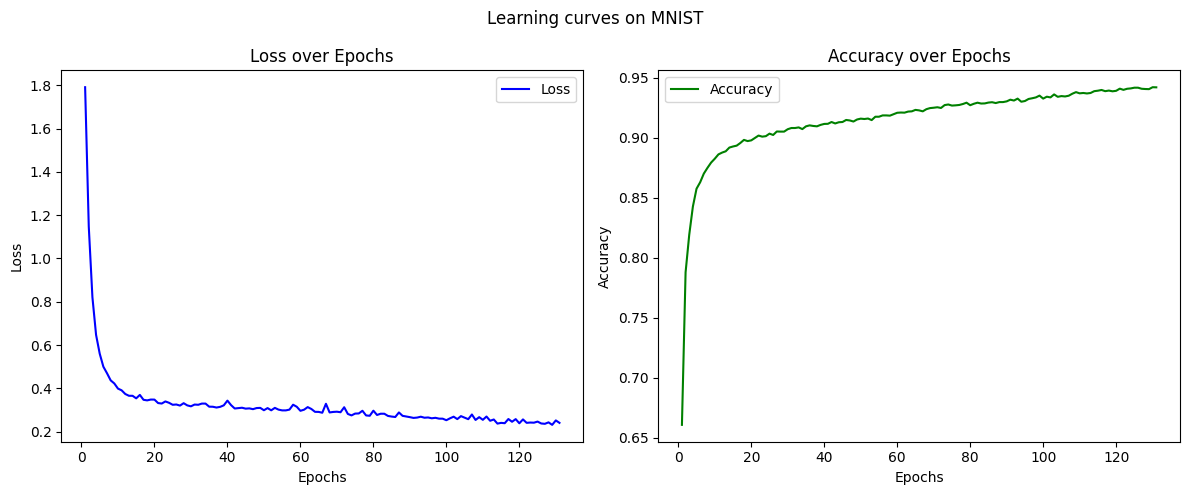

In [37]:
import math
import gc

gc.collect()

losses, accuracies, elapsed = train_n_rounds_hybrid(
    pool_mnist,
    T_final=T_FINAL_MIN * 60,
    clients_per_round=math.ceil(len(pool_mnist.clients) * C),
    problem="mnist"
)

# save data
save_data(pool_mnist, losses, accuracies, elapsed, "dynhybrid_400_mnist")

plot_loss_accuracy(losses, accuracies, title="Learning curves on MNIST")


Running round: 1 - Time elapsed: 0.0 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180
Current T round: 180.0
Max T round: 180.0
Min T round: 180.0
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.000000000000156/30.064586239736208 [00:30<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 143.29805326461792 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1000, test loss: 2.3171, round time: 177.8918023109436

Running round: 2 - Time elapsed: 177.89180374145508 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.0
Current T round: 172.34143294252996
Max T round: 180.0
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.19038088266244343
Time upload: 0.36172367705864267
Time upload: 0.5330664714548419
Time upload: 0.6853711775847964
Time upload: 0.7995997071822623
Time upload: 0.8567139719809952
Time upload: 0.8947901485134838
Time upload: 0.9328663250459724
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.20000000000019/32.28587665511367 [00:32<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 132.58260440826416 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1271, test loss: 2.7883, round time: 168.63366317749023

Running round: 3 - Time elapsed: 346.5271065235138 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.34143294252996
Current T round: 175.7602940604553
Max T round: 180.0
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.70000000000018/31.715122058272392 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 122.15402555465698 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1173, test loss: 3.1091, round time: 157.32164406776428

Running round: 4 - Time elapsed: 503.8505346775055 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.7602940604553
Current T round: 177.16595838753116
Max T round: 180.0
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.15521366182346005
Time upload: 0.2949059574645741
Time upload: 0.43459825310568817
Time upload: 0.5587691825644562
Time upload: 0.6518973796585322
Time upload: 0.6984614782055703
Time upload: 0.7295042105702623
Time upload: 0.7605469429349543
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 37.40000000000026/37.46382072980601 [00:37<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 134.99185490608215 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1726, test loss: 3.1546, round time: 176.43906235694885

Running round: 5 - Time elapsed: 680.2912018299103 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.16595838753116
Current T round: 175.3937785802141
Max T round: 180.0
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1625771370671059
Time upload: 0.3088965604275012
Time upload: 0.4227005563744753
Time upload: 0.5365045523214494
Time upload: 0.6177931208550024
Time upload: 0.6990816893885553
Time upload: 0.7478548305086871
Time upload: 0.7803702579221082
Time upload: 0.7966279716288188
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model

Distributing model...: 100%|█████████▉| 32.800000000000196/32.85838540016724 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 121.3366117477417 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1828, test loss: 2.8551, round time: 158.178893327713

Running round: 6 - Time elapsed: 838.4722208976746 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.3937785802141
Current T round: 177.95404289860502
Max T round: 180.0
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.2000000000002/33.271244210309064 [00:33<00:00,  1.01s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 126.94099187850952 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2350, test loss: 2.4614, round time: 163.5534439086914

Running round: 7 - Time elapsed: 1002.0273141860962 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.95404289860502
Current T round: 178.02220533852312
Max T round: 180.0
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.19762321586303577
Time upload: 0.37548411013976807
Time upload: 0.5138203612438932
Time upload: 0.6521566123480179
Time upload: 0.7509682202795356
Time upload: 0.8497798282110532
Time upload: 0.9090667929699638
Time upload: 0.9485914361425709
Time upload: 0.9683537577288744
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing mo

Distributing model...: 100%|█████████▉| 33.1000000000002/33.16817145208221 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 123.42321062088013 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2057, test loss: 2.8985, round time: 160.44562244415283

Running round: 8 - Time elapsed: 1162.474461555481 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.02220533852312
Current T round: 174.90249974750856
Max T round: 180.0
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17266340010707296
Time upload: 0.32806046020343865
Time upload: 0.4834575202998045
Time upload: 0.6215882403854626
Time upload: 0.7251862804497061
Time upload: 0.7942516404925352
Time upload: 0.8287843205139497
Time upload: 0.8460506605246569
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.70000000000021/33.70588912396332 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 135.62237572669983 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2572, test loss: 2.4820, round time: 173.2790596485138

Running round: 9 - Time elapsed: 1335.7551772594452 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.90249974750856
Current T round: 178.8679323445733
Max T round: 180.0
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.20000000000016/30.28228344317603 [00:30<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 152.55357384681702 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1723, test loss: 3.5459, round time: 186.1813986301422

Running round: 10 - Time elapsed: 1521.938306093216 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.8679323445733
Current T round: 185.22858052672095
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.15456796535144607
Time upload: 0.3091359307028922
Time upload: 0.4637038960543385
Time upload: 0.6182718614057844
Time upload: 0.7213171716400816
Time upload: 0.790014045129613
Time upload: 0.8243624818743788
Time upload: 0.8415367002467616
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.50000000000015/29.52516515871635 [00:29<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 147.86539435386658 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2412, test loss: 2.6387, round time: 181.29390335083008

Running round: 11 - Time elapsed: 1703.2337129116058 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 185.22858052672095
Current T round: 178.6775782401209
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.30000000000019/32.34596128950137 [00:32<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 133.61138606071472 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2234, test loss: 2.7215, round time: 169.26890444755554

Running round: 12 - Time elapsed: 1872.504076242447 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.6775782401209
Current T round: 177.4169415685969
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.400000000000148/29.421928756257923 [00:29<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 154.54903435707092 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2169, test loss: 3.0761, round time: 187.44535493850708

Running round: 13 - Time elapsed: 2059.9510729312897 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.4169415685969
Current T round: 179.4951717829525
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.00000000000023/35.0945084144951 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 130.7154200077057 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2853, test loss: 2.3356, round time: 169.27054238319397

Running round: 14 - Time elapsed: 2229.223255634308 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.4951717829525
Current T round: 175.85218905286192
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.100000000000158/30.108457049306246 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 147.3041045665741 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2772, test loss: 2.6257, round time: 180.8499915599823

Running round: 15 - Time elapsed: 2410.0749096870422 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.85218905286192
Current T round: 177.17432508477162
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.40000000000019/32.40157101118611 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 120.55716729164124 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2652, test loss: 2.8744, round time: 156.36035990715027

Running round: 16 - Time elapsed: 2566.436707019806 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.17432508477162
Current T round: 176.8968977011149
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.20286847395554614
Time upload: 0.40573694791109216
Time upload: 0.6086054218666385
Time upload: 0.8114738958221849
Time upload: 1.015067820258129
Time upload: 1.1986408958079977
Time upload: 1.3621931224717914
Time upload: 1.5259871659623845
Time upload: 1.6692767269133035
Time upload: 1.792303622151348
Time upload: 1.8948260348497183
Time upload: 

Distributing model...: 100%|█████████▉| 34.00000000000021/34.01155843707538 [00:34<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 124.79390120506287 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2399, test loss: 2.9287, round time: 163.2950873374939

Running round: 17 - Time elapsed: 2729.733263731003 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.8968977011149
Current T round: 178.46781782197039
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.100000000000158/30.18238186667025 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 146.22363996505737 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3272, test loss: 2.4975, round time: 179.77395343780518

Running round: 18 - Time elapsed: 2909.508857011795 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.46781782197039
Current T round: 175.03589507540428
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.15237414758940585
Time upload: 0.30474829517881175
Time upload: 0.4571224427682177
Time upload: 0.6094965903576236
Time upload: 0.7110793554172276
Time upload: 0.7788011987902969
Time upload: 0.8126621204768315
Time upload: 0.8295925813200988
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.50000000000025/36.59638683813673 [00:37<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 133.112398147583 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2535, test loss: 3.3670, round time: 173.54811811447144

Running round: 19 - Time elapsed: 3083.0588195323944 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.03589507540428
Current T round: 178.78100410816188
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.00000000000023/35.029428358951115 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 126.2332136631012 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1950, test loss: 3.7714, round time: 164.6760585308075

Running round: 20 - Time elapsed: 3247.7366495132446 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.78100410816188
Current T round: 180.25029522415156
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17193575194384814
Time upload: 0.3438715038876962
Time upload: 0.5158072558315442
Time upload: 0.6877430077753927
Time upload: 0.802366842404625
Time upload: 0.8787827321574465
Time upload: 0.9169906770338573
Time upload: 0.9360946494720627
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.40000000000019/32.45871127347738 [00:32<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 141.50813913345337 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2512, test loss: 3.0476, round time: 177.77292823791504

Running round: 21 - Time elapsed: 3425.511082172394 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.25029522415156
Current T round: 174.5211394091846
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.1793176421578599
Time upload: 0.36028409036127984
Time upload: 0.5445481506558195
Time upload: 0.7288122109503592
Time upload: 0.9163738833360185
Time upload: 1.1039355557216777
Time upload: 1.2752142699371105
Time upload: 1.4089806496754116
Time upload: 1.5443958354592726
Time upload: 1.6798110212431336
Time upload: 1.777713872549863
Time upload: 

Distributing model...: 100%|█████████▉| 35.10000000000023/35.13173988398722 [00:35<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 135.21825790405273 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2596, test loss: 2.4159, round time: 174.86625385284424

Running round: 22 - Time elapsed: 3600.378814935684 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.5211394091846
Current T round: 184.38748821588825
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.17410480384647256
Time upload: 0.35225329505721176
Time upload: 0.5344454736322175
Time upload: 0.7166376522072229
Time upload: 0.9109608928750281
Time upload: 1.0878736531581867
Time upload: 1.2473759330566985
Time upload: 1.4068782129552102
Time upload: 1.557057387197608
Time upload: 1.6857823936910916
Time upload: 1.7930532324356614
Time upload:

Distributing model...: 100%|█████████▉| 30.500000000000163/30.50540330633629 [00:30<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 144.72485780715942 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2165, test loss: 3.1717, round time: 179.69888424873352

Running round: 23 - Time elapsed: 3780.0794200897217 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.38748821588825
Current T round: 177.36006960411183
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.16852110342842797
Time upload: 0.3375233928054832
Time upload: 0.5065256821825385
Time upload: 0.6760091575082215
Time upload: 0.8464550047311593
Time upload: 1.001011113508509
Time upload: 1.1387151119430148
Time upload: 1.2590858140860506
Time upload: 1.3626044058862437
Time upload: 1.431937591052124
Time upload: 1.5012707762180042
Time upload:

Distributing model...: 100%|█████████▉| 34.30000000000022/34.31685121190719 [00:34<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 123.59936141967773 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2727, test loss: 2.5622, round time: 162.53008484840393

Running round: 24 - Time elapsed: 3942.610965490341 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.36006960411183
Current T round: 180.467354630097
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.60000000000019/32.64150269554707 [00:33<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 128.7721083164215 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2582, test loss: 3.0030, round time: 164.74477887153625

Running round: 25 - Time elapsed: 4107.357608556747 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.467354630097
Current T round: 175.17692878879097
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18489367032043671
Time upload: 0.3512979736088298
Time upload: 0.5177022768972229
Time upload: 0.6656172131535719
Time upload: 0.7765534153458337
Time upload: 0.8320215164419645
Time upload: 0.8690002505060518
Time upload: 0.905978984570139
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.500000000000178/31.553217275750097 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 125.11464977264404 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2670, test loss: 2.9929, round time: 160.4396152496338

Running round: 26 - Time elapsed: 4267.798921108246 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.17692878879097
Current T round: 180.8648953179011
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.60000000000019/32.61290959169888 [00:33<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 155.20726466178894 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2932, test loss: 2.6557, round time: 191.3089632987976

Running round: 27 - Time elapsed: 4459.109614849091 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.8648953179011
Current T round: 175.27532655320854
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16793222405792588
Time upload: 0.33586444811585175
Time upload: 0.5037966721737777
Time upload: 0.6717288962317035
Time upload: 0.7836837122703207
Time upload: 0.8583202562960656
Time upload: 0.895638528308938
Time upload: 0.9142976643153742
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.60000000000021/33.61614987130657 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 122.78738689422607 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2865, test loss: 2.8911, round time: 160.42138266563416

Running round: 28 - Time elapsed: 4619.532820701599 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.27532655320854
Current T round: 178.46758913653306
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.500000000000206/33.502367033765104 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 131.95344471931458 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3227, test loss: 2.2139, round time: 168.86542534828186

Running round: 29 - Time elapsed: 4788.399755239487 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.46758913653306
Current T round: 173.18525298941876
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 29.800000000000153/29.8736791525249 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 120.9156346321106 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2571, test loss: 3.1057, round time: 154.11678791046143

Running round: 30 - Time elapsed: 4942.51798415184 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.18525298941876
Current T round: 177.93447773083028
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.70000000000021/33.77743295477478 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 135.9445493221283 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3055, test loss: 2.7552, round time: 173.0679121017456

Running round: 31 - Time elapsed: 5115.587397575378 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.93447773083028
Current T round: 174.30618743281377
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17328041137146347
Time upload: 0.34656082274292693
Time upload: 0.5198412341143903
Time upload: 0.6931216454858533
Time upload: 0.8086419197334953
Time upload: 0.88565543589859
Time upload: 0.9241621939811373
Time upload: 0.943415573022411
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.70000000000024/35.77061681733685 [00:36<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 124.852609872818 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2937, test loss: 3.2553, round time: 164.49540495872498

Running round: 32 - Time elapsed: 5280.084627628326 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.30618743281377
Current T round: 177.77935471153
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.800000000000153/29.89417373827174 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 149.77628302574158 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2886, test loss: 2.7891, round time: 182.99504494667053

Running round: 33 - Time elapsed: 5463.08105969429 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.77935471153
Current T round: 184.2069727230101
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17741309054239865
Time upload: 0.3370848720305575
Time upload: 0.47901534446447647
Time upload: 0.6209458168983955
Time upload: 0.7096523621695948
Time upload: 0.7806175983865543
Time upload: 0.8338415255492739
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.30000000000016/30.39386621453499 [00:30<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 146.18355917930603 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3014, test loss: 2.4805, round time: 180.326917886734

Running round: 34 - Time elapsed: 5643.4095849990845 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 184.2069727230101
Current T round: 173.93224311022223
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.50000000000022/34.56958173754909 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 131.45399808883667 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2801, test loss: 3.1255, round time: 169.40007305145264

Running round: 35 - Time elapsed: 5812.811431646347 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.93224311022223
Current T round: 177.10707152950118
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16623493876438059
Time upload: 0.31584638365232315
Time upload: 0.46545782854026585
Time upload: 0.5984457795517701
Time upload: 0.6981867428103983
Time upload: 0.7646807183161504
Time upload: 0.7979277060690264
Time upload: 0.8145511999454644
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.800000000000196/32.807472889850054 [00:33<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 125.96118593215942 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3153, test loss: 2.3774, round time: 162.62168788909912

Running round: 36 - Time elapsed: 5975.4347224235535 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.10707152950118
Current T round: 173.49677386873853
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16879144093239454
Time upload: 0.32070373777154954
Time upload: 0.45573689051746497
Time upload: 0.5907700432633805
Time upload: 0.6751657637295776
Time upload: 0.7426823401025353
Time upload: 0.7933197723822536
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.800000000000182/31.818036957816016 [00:32<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 135.01753211021423 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2811, test loss: 2.8356, round time: 170.5568790435791

Running round: 37 - Time elapsed: 6145.993049383163 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.49677386873853
Current T round: 174.795031622665
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.100000000000158/30.11235431791271 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 142.72509860992432 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2817, test loss: 2.8919, round time: 176.24647974967957

Running round: 38 - Time elapsed: 6322.241045951843 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.795031622665
Current T round: 178.92114067343854
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.400000000000148/29.425620691619883 [00:29<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 141.83178424835205 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2749, test loss: 3.5548, round time: 174.5791893005371

Running round: 39 - Time elapsed: 6496.821745872498 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.92114067343854
Current T round: 178.22230139457986
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.700000000000152/29.79461795629735 [00:30<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 140.9015417098999 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2868, test loss: 3.0827, round time: 174.12538623809814

Running round: 40 - Time elapsed: 6670.9493091106415 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.22230139457986
Current T round: 178.50849060202518
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.000000000000142/29.032329624458 [00:29<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 141.28120017051697 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3170, test loss: 2.6594, round time: 173.66859889030457

Running round: 41 - Time elapsed: 6844.619347572327 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.50849060202518
Current T round: 174.66486281684857
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.100000000000172/31.18867939382859 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 150.76586985588074 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3362, test loss: 2.5122, round time: 185.29029965400696

Running round: 42 - Time elapsed: 7029.91129732132 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.66486281684857
Current T round: 182.58309967048507
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.2000000000002/33.20922878284299 [00:33<00:00,  1.01s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 128.5575511455536 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2881, test loss: 2.8399, round time: 165.12146162986755

Running round: 43 - Time elapsed: 7195.034417390823 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.58309967048507
Current T round: 179.08428512114318
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.30000000000019/32.39628794441387 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 144.94346022605896 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2925, test loss: 2.3784, round time: 180.68013834953308

Running round: 44 - Time elapsed: 7375.716290712357 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.08428512114318
Current T round: 177.13842412400507
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.70000000000021/33.79087040048426 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 126.5671694278717 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2937, test loss: 3.3712, round time: 163.76364922523499

Running round: 45 - Time elapsed: 7539.481414079666 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.13842412400507
Current T round: 175.80847120580898
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.1872123125559305
Time upload: 0.37511889724637365
Time upload: 0.5637197540713293
Time upload: 0.7523206108962849
Time upload: 0.9430042841247788
Time upload: 1.1149667260976799
Time upload: 1.2682079368149881
Time upload: 1.4020336441421906
Time upload: 1.5185266644828253
Time upload: 1.5961886780432484
Time upload: 1.6738506916036715
Time upload:

Distributing model...: 100%|█████████▉| 33.0000000000002/33.0628519073803 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 129.88455033302307 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3879, test loss: 2.2420, round time: 167.6056785583496

Running round: 46 - Time elapsed: 7707.088636636734 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.80847120580898
Current T round: 175.15681468810735
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.300000000000246/36.39357425228555 [00:36<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 131.34636521339417 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3433, test loss: 2.8060, round time: 171.14061403274536

Running round: 47 - Time elapsed: 7878.231002807617 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.15681468810735
Current T round: 178.87149057912552
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17902958021673188
Time upload: 0.34015620241179056
Time upload: 0.5012828246068493
Time upload: 0.6445064887802348
Time upload: 0.7519242369102739
Time upload: 0.8056331109752934
Time upload: 0.8414390270186398
Time upload: 0.8772449430619862
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.50000000000019/32.56119520834437 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 119.89069366455078 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3677, test loss: 2.5621, round time: 156.26752710342407

Running round: 48 - Time elapsed: 8034.500207424164 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.87149057912552
Current T round: 174.6962999209755
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.20000000000019/32.23960031340961 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 123.64836955070496 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3551, test loss: 2.2871, round time: 159.24637293815613

Running round: 49 - Time elapsed: 8193.748107910156 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.6962999209755
Current T round: 174.74098657021997
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.300000000000175/31.382160782684252 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 119.65512824058533 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3274, test loss: 2.8951, round time: 154.416095495224

Running round: 50 - Time elapsed: 8348.165771007538 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.74098657021997
Current T round: 177.47583291849156
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.60000000000018/31.645297344424716 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 126.21874022483826 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3378, test loss: 2.7554, round time: 161.2469117641449

Running round: 51 - Time elapsed: 8509.414509296417 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.47583291849156
Current T round: 176.1171127251346
Max T round: 185.22858052672095
Min T round: 172.34143294252996
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.900000000000183/31.938324859151802 [00:32<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 138.18204283714294 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4040, test loss: 2.1615, round time: 173.48215913772583

Running round: 52 - Time elapsed: 8682.898970365524 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.1171127251346
Current T round: 171.93509746164355
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 30.90000000000017/30.90054257377022 [00:31<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 124.5076310634613 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3488, test loss: 2.3093, round time: 158.78338861465454

Running round: 53 - Time elapsed: 8841.68397307396 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 171.93509746164355
Current T round: 180.39939995498725
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1555939232121473
Time upload: 0.29562845410307986
Time upload: 0.4201035926727977
Time upload: 0.5445787312425155
Time upload: 0.6223756928485892
Time upload: 0.6846132621334481
Time upload: 0.7312914390970923
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.200000000000244/36.25430299335043 [00:36<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 132.6625075340271 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3005, test loss: 3.2119, round time: 172.7457251548767

Running round: 54 - Time elapsed: 9014.431155920029 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.39939995498725
Current T round: 175.3908535607385
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.40000000000019/32.47128244511888 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 118.74208116531372 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3317, test loss: 2.8094, round time: 154.55474758148193

Running round: 55 - Time elapsed: 9168.987425327301 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.3908535607385
Current T round: 176.29171539033976
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 29.700000000000152/29.793944296802493 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 121.26225733757019 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3793, test loss: 2.2638, round time: 154.32128930091858

Running round: 56 - Time elapsed: 9323.31037402153 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.29171539033976
Current T round: 172.70432557289925
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.2000000000002/33.24260840513929 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 130.32398629188538 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3449, test loss: 2.6591, round time: 166.95095133781433

Running round: 57 - Time elapsed: 9490.26324915886 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.70432557289925
Current T round: 180.0943109207228
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.188211744403349
Time upload: 0.35760231436636297
Time upload: 0.4893505354487071
Time upload: 0.6210987565310516
Time upload: 0.7152046287327263
Time upload: 0.8093105009344009
Time upload: 0.8657740242554057
Time upload: 0.9034163731360756
Time upload: 0.9222375475764105
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distr

Distributing model...: 100%|█████████▉| 29.200000000000145/29.204642316547112 [00:29<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 147.74771881103516 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3793, test loss: 2.2634, round time: 180.85507225990295

Running round: 58 - Time elapsed: 9671.119860649109 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.0943109207228
Current T round: 171.95706452906035
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.3000000000002/33.37599749215659 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 133.53876638412476 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3515, test loss: 2.7792, round time: 170.23865675926208

Running round: 59 - Time elapsed: 9841.360758543015 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 171.95706452906035
Current T round: 177.27990410354596
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.3000000000002/33.33164457675634 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 136.73480796813965 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3814, test loss: 2.4862, round time: 173.4974720478058

Running round: 60 - Time elapsed: 10014.860345125198 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.27990410354596
Current T round: 177.7237164978924
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.17386223438563894
Time upload: 0.3477244687712777
Time upload: 0.5215867031569165
Time upload: 0.6954489375425552
Time upload: 0.8711032477006813
Time upload: 1.0121045826998454
Time upload: 1.154300634880667
Time upload: 1.2970940456523177
Time upload: 1.4040397640833484
Time upload: 1.4936589949348982
Time upload: 1.565354379616138
Time upload: 1

Distributing model...: 100%|█████████▉| 32.800000000000196/32.81478161038989 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 118.77018690109253 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3455, test loss: 2.3999, round time: 156.2074933052063

Running round: 61 - Time elapsed: 10171.06952047348 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.7237164978924
Current T round: 178.26319520651427
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.50000000000022/34.58915610363135 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 134.29017400741577 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3524, test loss: 2.7183, round time: 172.23417901992798

Running round: 62 - Time elapsed: 10343.305415153503 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.26319520651427
Current T round: 174.00893269693904
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16357803183660338
Time upload: 0.31079826048954634
Time upload: 0.44166068595882885
Time upload: 0.5725231114281114
Time upload: 0.654312127346413
Time upload: 0.7197433400810542
Time upload: 0.7688167496320352
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.30000000000022/34.37601125523772 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 123.27516961097717 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3624, test loss: 2.2171, round time: 161.3947398662567

Running round: 63 - Time elapsed: 10504.701568365097 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.00893269693904
Current T round: 176.6757146670181
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.300000000000246/36.337879470898045 [00:36<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 131.2485387325287 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3499, test loss: 2.8349, round time: 171.00033831596375

Running round: 64 - Time elapsed: 10675.703353643417 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.6757146670181
Current T round: 176.9747957462437
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.19144279311160342
Time upload: 0.3637413069120466
Time upload: 0.4977512620901691
Time upload: 0.6317612172682916
Time upload: 0.7274826138240934
Time upload: 0.8232040103798952
Time upload: 0.8806368483133763
Time upload: 0.918925406935697
Time upload: 0.9380696862468574
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distr

Distributing model...: 100%|█████████▉| 30.600000000000165/30.686346021340064 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 134.7286524772644 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3868, test loss: 2.1953, round time: 169.15428614616394

Running round: 65 - Time elapsed: 10844.859184503555 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.9747957462437
Current T round: 178.237451802478
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.500000000000206/33.54295387418261 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 126.47107577323914 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3222, test loss: 3.1149, round time: 163.5617709159851

Running round: 66 - Time elapsed: 11008.422584056854 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.237451802478
Current T round: 177.24422211233556
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.70000000000021/33.79860063273543 [00:34<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 128.93740487098694 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3585, test loss: 2.8673, round time: 166.02254700660706

Running round: 67 - Time elapsed: 11174.446954250336 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.24422211233556
Current T round: 177.1373272461983
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.800000000000168/30.80321431423756 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 147.43667101860046 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3442, test loss: 3.1758, round time: 181.62453627586365

Running round: 68 - Time elapsed: 11356.07318019867 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.1373272461983
Current T round: 181.14459701353996
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.500000000000178/31.576620142311235 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 124.01367568969727 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4081, test loss: 2.4234, round time: 158.8628933429718

Running round: 69 - Time elapsed: 11514.937532901764 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.14459701353996
Current T round: 175.08254849062052
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.17506195210126427
Time upload: 0.3510873981111791
Time upload: 0.5290398319383952
Time upload: 0.7069922657656111
Time upload: 0.8684019982913512
Time upload: 1.0298117308170913
Time upload: 1.174678762041356
Time upload: 1.320509287174271
Time upload: 1.4303639279782825
Time upload: 1.540218568782294
Time upload: 1.651036703494956
Time upload: 1.

Distributing model...: 100%|█████████▉| 34.00000000000021/34.02716365397219 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 124.349289894104 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3743, test loss: 2.5312, round time: 162.88468503952026

Running round: 70 - Time elapsed: 11677.823711156845 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.08254849062052
Current T round: 177.43295218195723
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.800000000000196/32.83036598650689 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 121.92990922927856 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3530, test loss: 3.0844, round time: 158.24915385246277

Running round: 71 - Time elapsed: 11836.074481964111 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.43295218195723
Current T round: 176.30966943803452
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16246409797287248
Time upload: 0.32492819594574507
Time upload: 0.48739229391861777
Time upload: 0.64985639189149
Time upload: 0.7581657905400715
Time upload: 0.8303720563057925
Time upload: 0.866475189188653
Time upload: 0.8845267556300832
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.200000000000173/31.252416278958986 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 121.28256940841675 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3599, test loss: 3.0236, round time: 156.40391373634338

Running round: 72 - Time elapsed: 11992.480127096176 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.30966943803452
Current T round: 176.78106055857464
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.200000000000216/34.25740378350226 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 125.3601393699646 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3748, test loss: 2.3018, round time: 163.02941846847534

Running round: 73 - Time elapsed: 12155.511285305023 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.78106055857464
Current T round: 177.88189490769108
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16302994892099712
Time upload: 0.30975690294989444
Time upload: 0.4564838569787916
Time upload: 0.5869078161155894
Time upload: 0.6847257854681879
Time upload: 0.7499377650365868
Time upload: 0.7825437548207863
Time upload: 0.798846749712886
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.800000000000196/32.86226828372764 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 127.01522612571716 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3032, test loss: 2.6420, round time: 163.65142679214478

Running round: 74 - Time elapsed: 12319.16434264183 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.88189490769108
Current T round: 173.7022900911869
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.19464044007633094
Time upload: 0.3698168361450287
Time upload: 0.5060651441984603
Time upload: 0.6423134522518922
Time upload: 0.7396336722900578
Time upload: 0.8369538923282235
Time upload: 0.8953460243511229
Time upload: 0.9342741123663891
Time upload: 0.9537381563740223
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Dis

Distributing model...: 100%|█████████▉| 30.20000000000016/30.29507400756567 [00:30<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 120.32130360603333 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3750, test loss: 2.3146, round time: 154.3730001449585

Running round: 75 - Time elapsed: 12473.539024353027 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.7022900911869
Current T round: 182.59295949016982
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17145383997487854
Time upload: 0.32576229595226913
Time upload: 0.44577998393468393
Time upload: 0.565797671917099
Time upload: 0.6515245919045384
Time upload: 0.7372515118919778
Time upload: 0.7886876638844414
Time upload: 0.8229784318794172
Time upload: 0.8401238158769051
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Di

Distributing model...: 100%|█████████▉| 32.20000000000019/32.207756627806624 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 127.8242290019989 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3725, test loss: 3.1882, round time: 163.87947034835815

Running round: 76 - Time elapsed: 12637.419923067093 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 182.59295949016982
Current T round: 174.31648131938445
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18178489738689765
Time upload: 0.3453913050351054
Time upload: 0.5089977126833131
Time upload: 0.654425630592831
Time upload: 0.7634965690249694
Time upload: 0.8362105279797284
Time upload: 0.8725675074571079
Time upload: 0.8907459971957976
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.50000000000022/34.59856878593097 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 139.83214783668518 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4536, test loss: 2.1899, round time: 178.16954016685486

Running round: 77 - Time elapsed: 12815.590951681137 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.31648131938445
Current T round: 180.0829949055633
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.2000000000002/33.259111098187155 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 124.51114988327026 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3862, test loss: 2.3741, round time: 161.098078250885

Running round: 78 - Time elapsed: 12976.690581798553 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.0829949055633
Current T round: 178.0364130157968
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.50000000000019/32.57779885051567 [00:32<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 132.47631454467773 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3837, test loss: 2.0252, round time: 168.36397743225098

Running round: 79 - Time elapsed: 13145.056269407272 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.0364130157968
Current T round: 178.13990518646185
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 37.20000000000026/37.20761756971167 [00:37<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 134.61932110786438 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4021, test loss: 2.7391, round time: 175.30721306800842

Running round: 80 - Time elapsed: 13320.364978075027 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.13990518646185
Current T round: 176.24597115915813
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.40000000000019/32.40570315458516 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 131.45959997177124 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4692, test loss: 2.0871, round time: 167.248291015625

Running round: 81 - Time elapsed: 13487.615166664124 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.24597115915813
Current T round: 173.56095837938778
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.14364985970581154
Time upload: 0.2872997194116231
Time upload: 0.43094957911743464
Time upload: 0.5745994388232462
Time upload: 0.6703660119604539
Time upload: 0.7342103940519257
Time upload: 0.7661325850976616
Time upload: 0.7820936806205295
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.40000000000022/34.48464613997142 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 131.23408436775208 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4160, test loss: 2.7357, round time: 169.5709991455078

Running round: 82 - Time elapsed: 13657.187644004822 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.56095837938778
Current T round: 178.55560715653718
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.9000000000002/32.98830422174167 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 126.73047924041748 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3551, test loss: 3.5809, round time: 163.11813950538635

Running round: 83 - Time elapsed: 13820.307411432266 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.55560715653718
Current T round: 175.6193812552721
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.500000000000206/33.593479141195196 [00:34<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 121.81436944007874 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3597, test loss: 3.5452, round time: 158.69648480415344

Running round: 84 - Time elapsed: 13979.00549864769 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.6193812552721
Current T round: 174.45696017779815
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.100000000000172/31.163944322361097 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 123.7335844039917 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3858, test loss: 2.7857, round time: 158.17315316200256

Running round: 85 - Time elapsed: 14137.180138587952 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.45696017779815
Current T round: 178.366182256516
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.900000000000155/29.94641637328513 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 144.87070870399475 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3834, test loss: 2.8658, round time: 178.0914375782013

Running round: 86 - Time elapsed: 14315.273053407669 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.366182256516
Current T round: 176.35914641297035
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1403509522085997
Time upload: 0.2807019044171994
Time upload: 0.42105285662579905
Time upload: 0.5614038088343989
Time upload: 0.654971110306799
Time upload: 0.7173493112883991
Time upload: 0.7485384117791991
Time upload: 0.7641329620245991
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 30.90000000000017/30.994164348478975 [00:31<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 119.93344473838806 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3735, test loss: 2.7302, round time: 154.75028562545776

Running round: 87 - Time elapsed: 14470.024857521057 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.35914641297035
Current T round: 178.84356617086985
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.100000000000158/30.119116366821874 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 145.35746335983276 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4418, test loss: 2.1309, round time: 178.89447331428528

Running round: 88 - Time elapsed: 14648.920823335648 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.84356617086985
Current T round: 176.2579589974829
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16927556260346918
Time upload: 0.32162356894659144
Time upload: 0.4570440190293668
Time upload: 0.5924644691121421
Time upload: 0.6771022504138767
Time upload: 0.7448124754552644
Time upload: 0.7955951442363052
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 38.00000000000027/38.041763085120195 [00:38<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 134.33684849739075 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4550, test loss: 2.2186, round time: 176.2754259109497

Running round: 89 - Time elapsed: 14825.20071721077 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.2579589974829
Current T round: 177.93946506090433
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.17056285016233894
Time upload: 0.34112570032467787
Time upload: 0.5116885504870168
Time upload: 0.6822514006493557
Time upload: 0.855334810500802
Time upload: 1.0122861405553536
Time upload: 1.15310539081301
Time upload: 1.294764827633702
Time upload: 1.4186118115314281
Time upload: 1.5254865290692239
Time upload: 1.6145487936840537
Time upload: 1.6

Distributing model...: 100%|█████████▉| 31.800000000000182/31.852885264346405 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 153.90958046913147 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4619, test loss: 2.0733, round time: 190.21396946907043

Running round: 90 - Time elapsed: 15015.416400909424 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.93946506090433
Current T round: 178.32394331531742
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Time upload: 0
Time upload: 0.1565668347002067
Time upload: 0.3141619580975482
Time upload: 0.47381365888915916
Time upload: 0.6334653596807701
Time upload: 0.7951736378666504
Time upload: 0.9568819160525307
Time upload: 1.1251416952055127
Time upload: 1.29592807091324
Time upload: 1.4677427353181018
Time upload: 1.6213741196981977
Time upload: 1.7790304084906496
Time upload:

Distributing model...: 100%|█████████▉| 33.2000000000002/33.28905428012733 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 125.34197068214417 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4747, test loss: 2.1412, round time: 163.74847960472107

Running round: 91 - Time elapsed: 15179.167185783386 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.32394331531742
Current T round: 173.9273597849922
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.178859323933265
Time upload: 0.3398327154732034
Time upload: 0.5008061070131417
Time upload: 0.6438935661597535
Time upload: 0.7512091605197123
Time upload: 0.8048669576996917
Time upload: 0.8406388224863447
Time upload: 0.8764106872729976
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.30000000000019/32.36721351269645 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 138.02886962890625 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3784, test loss: 2.8403, round time: 174.2826051712036

Running round: 92 - Time elapsed: 15353.45145201683 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.9273597849922
Current T round: 178.23325249322653
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 30.800000000000168/30.860923446710807 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 124.40220212936401 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4725, test loss: 1.8205, round time: 158.5778932571411

Running round: 93 - Time elapsed: 15512.031000852585 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.23325249322653
Current T round: 178.12532171596578
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.10000000000024/36.14584818299271 [00:36<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 133.03823685646057 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4001, test loss: 2.1639, round time: 172.68793964385986

Running round: 94 - Time elapsed: 15684.720334529877 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.12532171596578
Current T round: 180.6872752627008
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16381274881648425
Time upload: 0.3112442227513201
Time upload: 0.42591314692285903
Time upload: 0.540582071094398
Time upload: 0.6224884455026402
Time upload: 0.7043948199108823
Time upload: 0.7535386445558275
Time upload: 0.7863011943191244
Time upload: 0.8026824692007728
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Di

Distributing model...: 100%|█████████▉| 31.00000000000017/31.03082904287303 [00:31<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 150.19048595428467 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4376, test loss: 2.3016, round time: 185.20056986808777

Running round: 95 - Time elapsed: 15869.922508716583 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.6872752627008
Current T round: 176.1809219656482
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.1694040894593787
Time upload: 0.3395558209026405
Time upload: 0.5097075523459023
Time upload: 0.6806069257730472
Time upload: 0.8353135322381374
Time upload: 0.9915154226709941
Time upload: 1.131524546141797
Time upload: 1.2722813115964833
Time upload: 1.377661975191527
Time upload: 1.4837902807704542
Time upload: 1.5899185863493812
Time upload: 1.

Distributing model...: 100%|█████████▉| 28.80000000000014/28.87979786701806 [00:29<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 150.05030226707458 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4249, test loss: 2.1821, round time: 183.43465924263

Running round: 96 - Time elapsed: 16053.358987569809 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.1809219656482
Current T round: 180.39671280361947
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.40000000000025/36.431466028167975 [00:36<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 138.55219888687134 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4151, test loss: 2.5900, round time: 178.34750652313232

Running round: 97 - Time elapsed: 16231.707926273346 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.39671280361947
Current T round: 174.38225627648444
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 28.500000000000135/28.540953066234305 [00:28<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 122.94556736946106 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4049, test loss: 2.4132, round time: 154.81631684303284

Running round: 98 - Time elapsed: 16386.52588582039 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.38225627648444
Current T round: 174.8705192490575
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 28.700000000000138/28.73711700431185 [00:29<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 124.77988576889038 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4490, test loss: 1.9267, round time: 156.83966255187988

Running round: 99 - Time elapsed: 16543.367404460907 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.8705192490575
Current T round: 179.92564723810239
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.15324700755400683
Time upload: 0.29116931435261306
Time upload: 0.41376692039581875
Time upload: 0.5363645264390244
Time upload: 0.612988030216028
Time upload: 0.6742868332376308
Time upload: 0.720260935503833
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 37.80000000000027/37.80287400317105 [00:38<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 124.67274308204651 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4283, test loss: 2.1284, round time: 166.31719517707825

Running round: 100 - Time elapsed: 16709.686275720596 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.92564723810239
Current T round: 177.80159558664616
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.20342961237994672
Time upload: 0.3865162635218988
Time upload: 0.5289169921878614
Time upload: 0.6713177208538237
Time upload: 0.7730325270437968
Time upload: 0.8747473332337699
Time upload: 0.9357762169477537
Time upload: 0.9764621394237429
Time upload: 0.9968051006617376
Selected data length (|D_UL|): 153600
Selected clients for this round: 4


Distributing model...: 100%|█████████▉| 37.80000000000027/37.829492926708426 [00:38<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 130.95014691352844 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4227, test loss: 2.5133, round time: 172.71327757835388

Running round: 101 - Time elapsed: 16882.401145219803 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.80159558664616
Current T round: 176.63653781974705
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.000000000000156/30.007596718345557 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 144.29160404205322 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4159, test loss: 2.4363, round time: 177.76970601081848

Running round: 102 - Time elapsed: 17060.172385931015 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.63653781974705
Current T round: 179.66103712973757
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16683995249946845
Time upload: 0.31699590974899006
Time upload: 0.4671518669985117
Time upload: 0.6006238289980861
Time upload: 0.7007278004977668
Time upload: 0.7507797862476072
Time upload: 0.7841477767475008
Time upload: 0.8175157672473944
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.70000000000018/31.731051105558016 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 147.72484016418457 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3645, test loss: 2.9838, round time: 183.3383822441101

Running round: 103 - Time elapsed: 17243.512403726578 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.66103712973757
Current T round: 177.62469167221312
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.30000000000019/32.32378868867661 [00:32<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 126.17735624313354 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4033, test loss: 2.9815, round time: 161.82066249847412

Running round: 104 - Time elapsed: 17405.334830760956 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.62469167221312
Current T round: 178.533278154429
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.50000000000019/32.53312521509017 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 146.48147797584534 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3999, test loss: 3.1882, round time: 182.4378936290741

Running round: 105 - Time elapsed: 17587.774364709854 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.533278154429
Current T round: 175.7893086645382
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 30.90000000000017/30.926362067367844 [00:31<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 121.20075416564941 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4207, test loss: 2.6443, round time: 155.59585452079773

Running round: 106 - Time elapsed: 17743.372111320496 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.7893086645382
Current T round: 177.5655983145203
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.15929576427791922
Time upload: 0.3026619521280465
Time upload: 0.4300985635503818
Time upload: 0.5575351749727171
Time upload: 0.6371830571116767
Time upload: 0.7009013628228443
Time upload: 0.7486900921062201
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 29.50000000000015/29.543157768767166 [00:29<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 115.85107278823853 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4075, test loss: 2.5358, round time: 149.12311100959778

Running round: 107 - Time elapsed: 17892.49719285965 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.5655983145203
Current T round: 178.34333274960954
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.10000000000023/35.146353617648224 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 125.30290389060974 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4184, test loss: 3.3074, round time: 163.87129974365234

Running round: 108 - Time elapsed: 18056.370112657547 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.34333274960954
Current T round: 173.71140824526321
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.800000000000196/32.81731474613428 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 125.07085227966309 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4662, test loss: 2.4667, round time: 161.23723554611206

Running round: 109 - Time elapsed: 18217.609004497528 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.71140824526321
Current T round: 173.41664854981923
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.70000000000025/36.731261364514936 [00:37<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 138.98624181747437 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4480, test loss: 2.6878, round time: 179.1239173412323

Running round: 110 - Time elapsed: 18396.734367370605 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.41664854981923
Current T round: 175.18535297458
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Time upload: 0
Time upload: 0.15576152069193477
Time upload: 0.29594688931467605
Time upload: 0.4361322579374175
Time upload: 0.5803557358232064
Time upload: 0.7326554322350907
Time upload: 0.8970694564361177
Time upload: 1.065521589900192
Time upload: 1.2339737233642658
Time upload: 1.3672354434269052
Time upload: 1.484921011420351
Time upload: 1.563378056749315
Time upload: 1.

Distributing model...: 100%|█████████▉| 33.90000000000021/33.92811833588302 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 122.68281698226929 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4725, test loss: 1.9661, round time: 161.34974765777588

Running round: 111 - Time elapsed: 18558.085532665253 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.18535297458
Current T round: 173.691344365587
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18974045379955598
Time upload: 0.36050686221915645
Time upload: 0.531273270638757
Time upload: 0.6830656336784019
Time upload: 0.7969099059581356
Time upload: 0.8728060874779581
Time upload: 0.9107541782378693
Time upload: 0.9297282236178249
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.700000000000195/32.79649445845122 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 125.28955554962158 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3757, test loss: 3.2957, round time: 161.90173196792603

Running round: 112 - Time elapsed: 18719.98887872696 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 173.691344365587
Current T round: 176.92293450526654
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.500000000000178/31.568687372411397 [00:31<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 130.29877042770386 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4269, test loss: 2.5126, round time: 165.1611258983612

Running round: 113 - Time elapsed: 18885.15168619156 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.92293450526654
Current T round: 178.01548710218233
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1674169200715129
Time upload: 0.3348338401430258
Time upload: 0.5022507602145387
Time upload: 0.6696676802860512
Time upload: 0.7812789603337261
Time upload: 0.8556864803655094
Time upload: 0.8928902403814011
Time upload: 0.9114921203893469
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.50000000000019/32.524343471540014 [00:33<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 147.75311398506165 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3904, test loss: 2.8505, round time: 184.14255142211914

Running round: 114 - Time elapsed: 19069.2957239151 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.01548710218233
Current T round: 181.5330155741694
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.700000000000152/29.701343027422517 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 146.78286337852478 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4043, test loss: 2.2676, round time: 179.96271300315857

Running round: 115 - Time elapsed: 19249.26007580757 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 181.5330155741694
Current T round: 177.91453612644355
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.00000000000023/35.006515426756 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 125.9319908618927 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3999, test loss: 3.3365, round time: 164.3447642326355

Running round: 116 - Time elapsed: 19413.606557369232 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.91453612644355
Current T round: 180.48908688801953
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.80000000000024/35.80150277539516 [00:36<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 129.28620958328247 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3996, test loss: 3.7368, round time: 168.52375411987305

Running round: 117 - Time elapsed: 19582.131932735443 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.48908688801953
Current T round: 172.1864853004106
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.200000000000173/31.250023138311235 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 122.50144410133362 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4759, test loss: 2.0081, round time: 157.11317658424377

Running round: 118 - Time elapsed: 19739.246789693832 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 172.1864853004106
Current T round: 175.44885447089158
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.50000000000025/36.54308396019147 [00:37<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 141.70199871063232 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3740, test loss: 2.3672, round time: 181.72193121910095

Running round: 119 - Time elapsed: 19920.970507860184 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.44885447089158
Current T round: 175.35455496358077
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.00000000000017/31.003439991547374 [00:31<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 123.14138293266296 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3917, test loss: 2.5031, round time: 157.5242042541504

Running round: 120 - Time elapsed: 20078.49642109871 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.35455496358077
Current T round: 174.49877371685037
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.500000000000206/33.576985712550986 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 126.00726389884949 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4729, test loss: 2.0314, round time: 162.9773292541504

Running round: 121 - Time elapsed: 20241.475234031677 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.49877371685037
Current T round: 178.8915331475486
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.1497131486734059
Time upload: 0.2994262973468118
Time upload: 0.4491394460202179
Time upload: 0.5988525946936236
Time upload: 0.698661360475894
Time upload: 0.7652005376640743
Time upload: 0.7984701262581644
Time upload: 0.8151049205552094
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.90000000000017/30.92590326214194 [00:31<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 146.4801812171936 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4014, test loss: 2.4562, round time: 181.26770901679993

Running round: 122 - Time elapsed: 20422.744678258896 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.8915331475486
Current T round: 175.05886308098079
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 28.600000000000136/28.693856361041405 [00:29<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 124.12593793869019 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3409, test loss: 4.1187, round time: 156.0919325351715

Running round: 123 - Time elapsed: 20578.838312864304 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.05886308098079
Current T round: 178.62790891468404
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.18076290804692724
Time upload: 0.34344952528916184
Time upload: 0.4699835609220111
Time upload: 0.5965175965548604
Time upload: 0.6868990505783241
Time upload: 0.7772805046017879
Time upload: 0.8315093770158661
Time upload: 0.8676619586252516
Time upload: 0.8857382494299444
Selected data length (|D_UL|): 153600
Selected clients for this round: 4


Distributing model...: 100%|█████████▉| 34.100000000000215/34.18166020066896 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 122.43621349334717 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3949, test loss: 2.7076, round time: 160.55856156349182

Running round: 124 - Time elapsed: 20739.39857149124 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.62790891468404
Current T round: 174.92190134874576
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.900000000000254/36.917368328511834 [00:37<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 127.87368583679199 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4253, test loss: 2.9067, round time: 168.22736048698425

Running round: 125 - Time elapsed: 20907.627633571625 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.92190134874576
Current T round: 177.0780890252357
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.500000000000234/35.55873036670427 [00:36<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 143.03243041038513 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3558, test loss: 3.8110, round time: 182.0079517364502

Running round: 126 - Time elapsed: 21089.63742661476 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.0780890252357
Current T round: 176.18280149004204
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.60000000000021/33.624226764651965 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 122.00068974494934 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4000, test loss: 2.7588, round time: 159.0150022506714

Running round: 127 - Time elapsed: 21248.65403819084 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.18280149004204
Current T round: 179.2523430270698
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.400000000000205/33.45887621824134 [00:33<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 123.69255113601685 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3415, test loss: 5.4099, round time: 160.5798351764679

Running round: 128 - Time elapsed: 21409.23569560051 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.2523430270698
Current T round: 178.24099833921045
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.40000000000022/34.47954247955558 [00:34<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 129.72110748291016 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3609, test loss: 3.6299, round time: 167.54553937911987

Running round: 129 - Time elapsed: 21576.782927036285 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.24099833921045
Current T round: 176.88118581482854
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.2114429783194788
Time upload: 0.40174165880700974
Time upload: 0.549751743630645
Time upload: 0.6977618284542806
Time upload: 0.8034833176140203
Time upload: 0.9092048067737599
Time upload: 0.9726377002696037
Time upload: 1.0149262959334995
Time upload: 1.0360705937654473
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
D

Distributing model...: 100%|█████████▉| 32.50000000000019/32.532917361719214 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 124.06680226325989 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4371, test loss: 2.7891, round time: 160.43460035324097

Running round: 130 - Time elapsed: 21737.219035863876 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.88118581482854
Current T round: 175.18220470549036
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.2000000000002/33.213439060215116 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 135.63420295715332 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3851, test loss: 2.6332, round time: 172.29762434959412

Running round: 131 - Time elapsed: 21909.518491268158 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 175.18220470549036
Current T round: 179.27531203759975
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.40000000000022/34.44050754821016 [00:34<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 120.22031378746033 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4177, test loss: 3.3635, round time: 158.0163218975067

Running round: 132 - Time elapsed: 22067.536237478256 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.27531203759975
Current T round: 177.93604652040102
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.16190691031757104
Time upload: 0.3238138206351422
Time upload: 0.48572073095271334
Time upload: 0.647627641270284
Time upload: 0.7555655814819978
Time upload: 0.827524208289807
Time upload: 0.8635035216937116
Time upload: 0.8814931783956639
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.3000000000002/33.35528642277404 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 129.67919540405273 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3599, test loss: 4.6951, round time: 166.8521659374237

Running round: 133 - Time elapsed: 22234.389981985092 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.93604652040102
Current T round: 174.67056029162038
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.20000000000019/32.213148079566864 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 123.71581983566284 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4058, test loss: 2.8784, round time: 159.28394746780396

Running round: 134 - Time elapsed: 22393.67534518242 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.67056029162038
Current T round: 180.55815070771172
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.800000000000182/31.82354218887129 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 123.26448965072632 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3963, test loss: 3.1230, round time: 158.39737248420715

Running round: 135 - Time elapsed: 22552.074196577072 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.55815070771172
Current T round: 177.07528579359845
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.17201506892368604
Time upload: 0.3268286309550035
Time upload: 0.4472391792015837
Time upload: 0.5676497274481641
Time upload: 0.6536572619100074
Time upload: 0.7396647963718507
Time upload: 0.7912693170489566
Time upload: 0.825672330833694
Time upload: 0.8428738377260626
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
D

Distributing model...: 100%|█████████▉| 32.60000000000019/32.631228079665235 [00:33<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 132.72504949569702 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4261, test loss: 2.6514, round time: 169.21796369552612

Running round: 136 - Time elapsed: 22721.293839931488 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.07528579359845
Current T round: 179.43779001077334
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.15849183951632428
Time upload: 0.3169836790326487
Time upload: 0.4754755185489731
Time upload: 0.6339673580652975
Time upload: 0.7396285844095137
Time upload: 0.8100694019723246
Time upload: 0.84528981075373
Time upload: 0.8629000151444327
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.20000000000023/35.20595747156184 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 144.47384119033813 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4812, test loss: 2.3632, round time: 183.52246165275574

Running round: 137 - Time elapsed: 22904.817944526672 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 179.43779001077334
Current T round: 174.25137141204516
Max T round: 185.22858052672095
Min T round: 171.93509746164355
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.1000000000002/33.145687926671 [00:33<00:00,  1.01s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 130.06621623039246 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4497, test loss: 2.8784, round time: 166.48154735565186

Running round: 138 - Time elapsed: 23071.30122280121 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 174.25137141204516
Current T round: 169.64989549865908
Max T round: 185.22858052672095
Min T round: 169.64989549865908
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.2000000000002/33.225961308171314 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 133.45900893211365 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4588, test loss: 2.6002, round time: 170.12261772155762

Running round: 139 - Time elapsed: 23241.425531625748 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 169.64989549865908
Current T round: 180.2301079521477
Max T round: 185.22858052672095
Min T round: 169.64989549865908
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.90000000000024/35.93222679899825 [00:36<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 131.89845967292786 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4583, test loss: 1.9487, round time: 171.25542831420898

Running round: 140 - Time elapsed: 23412.68233370781 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 180.2301079521477
Current T round: 176.9611742961985
Max T round: 185.22858052672095
Min T round: 169.64989549865908
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 28.80000000000014/28.832169495461418 [00:29<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 117.81879568099976 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4587, test loss: 2.6965, round time: 149.96949243545532

Running round: 141 - Time elapsed: 23562.653450250626 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 176.9611742961985
Current T round: 177.45122621306143
Max T round: 185.22858052672095
Min T round: 169.64989549865908
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.40000000000022/34.49097919273223 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 133.0151948928833 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.5094, test loss: 1.7050, round time: 170.86927962303162

Running round: 142 - Time elapsed: 23733.524361371994 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 177.45122621306143
Current T round: 178.32777779521717
Max T round: 185.22858052672095
Min T round: 169.64989549865908
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.900000000000155/29.954905137571522 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 145.48760271072388 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4432, test loss: 2.4229, round time: 178.8850281238556

Running round: 143 - Time elapsed: 23912.41088628769 seconds
Server requesting clients resources...
Server selecting clients to train locally...
Previous T round: 178.32777779521717
Current T round: 178.19003742051495
Max T round: 185.22858052672095
Min T round: 169.64989549865908
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Time upload: 0
Time upload: 0.15216040643692386
Time upload: 0.3043208128738476
Time upload: 0.45648121931077135
Time upload: 0.6086416257476951
Time upload: 0.7100818967056443
Time upload: 0.7777087440109437
Time upload: 0.8115221676635934
Time upload: 0.8284288794899183
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.10000000000023/35.14858999497488 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 125.75559878349304 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3976, test loss: 4.5818, round time: 164.78151106834412
Total clients selected: 601


,loss,accuracy,elapsed_time
0,2.317100,0.1000,177.891802
1,2.788289,0.1271,168.633663
2,3.109084,0.1173,157.321644
3,3.154591,0.1726,176.439062
4,2.855118,0.1828,158.178893
...,...,...,...
138,1.948703,0.4583,171.255428
139,2.696516,0.4587,149.969492
140,1.704968,0.5094,170.869280
141,2.422853,0.4432,178.885028


/opt/conda/lib/python3.10/site-packages/flex/data/lazy_indexable.py:115: RuntimeWarning: Pickling an LazyIndexable fully loads its into memory
  warnings.warn(  # noqa: B028


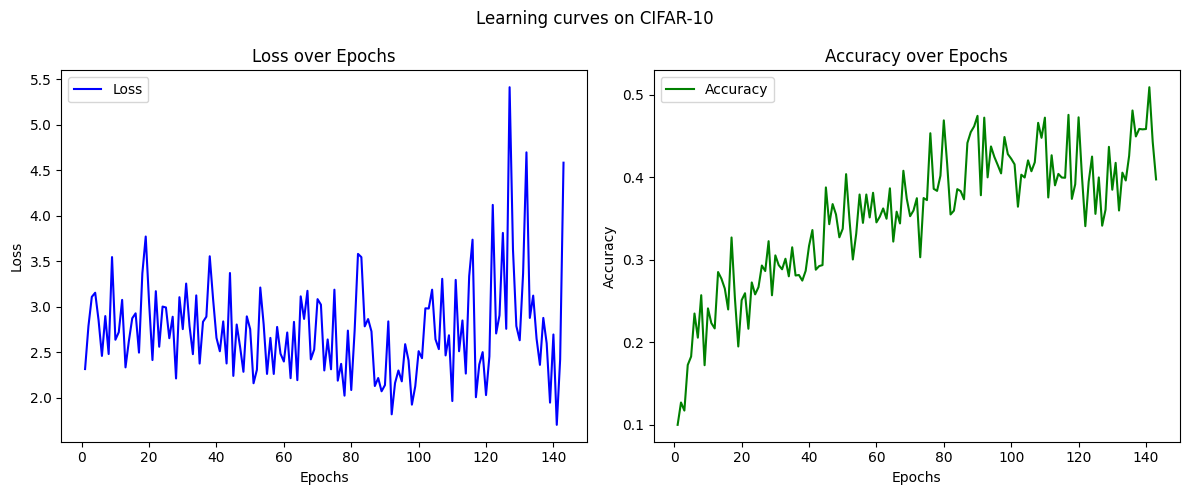

In [37]:
gc.collect()

losses, accuracies, elapsed = train_n_rounds_hybrid(
    pool_cifar,
    T_final=T_FINAL_MIN * 60,
    clients_per_round=math.ceil(len(pool_cifar.clients) * C),
    problem="cifar"
)

# save data
save_data(pool_cifar, losses, accuracies, elapsed, "dynhybrid_400_cifar")

plot_loss_accuracy(losses, accuracies, title="Learning curves on CIFAR-10")